#Wstęp

Funkcje te w pipeline należy umieścić np. w Cloud Functions do obsługi napływających danych przed wysłaniem ich do tematu. Funkcje te definiują sposób dostarczania danych do Pub/Sub.

W kolejnym kroku trzeba zrobić drugą Cloud Functions, która przyjmie dane z Pub/Sub następnie przetworzy i wrzuci dane do hurtowni.

```
publish_messages

publish_messages_with_custom_attributes

publish_messages_with_error_handler

publish_messages_with_batch_settings

publish_messages_with_flow_control_settings

publish_messages_with_retry_settings

publish_with_ordering_keys

resume_publish_with_ordering_keys
```


#Hipotetyczny pipeline

1. Aplikacja serwerowa spoza GCP wysyła dane do tematu A. Tworzę temat w GCP.

    ```
    gcloud pubsub topics create topic-a
    ```
2. Cloud Functions NR 1 zawierającą funkcję np.`resume_publish_with_ordering_keys` aktywuje sie na temacie A. i wysyła dane do tematu B.
    ```
    gcloud functions deploy function-one \
    --runtime python39 \
    --trigger-topic topic-a \
    --entry-point [NAZWA_FUNKCJI_W_PLIKU]  

    ```

3. Tworzę temat B

    ```
    gcloud pubsub topics create topic-b
    ```

4. Temat B przyjmuje dane z logiką działania zdefiniowaną w kroku 2.

5. Cloud Functions NR 2 aktywuje sie na temacie B i ładuje dane do BigQuery.

    ```
    gcloud functions deploy function-two \
    --runtime python39 \
    --trigger-topic topic-b \
    --entry-point [NAZWA_FUNKCJI_W_PLIKU]  # Nazwa funkcji w pliku function_two.py
    ```


[002 GSP094 Google Cloud Pub/Sub: Qwik Start – Python](https://www.cloudskillsboost.google/focuses/2775?catalog_rank=%7B%22rank%22%3A6%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=22532135)

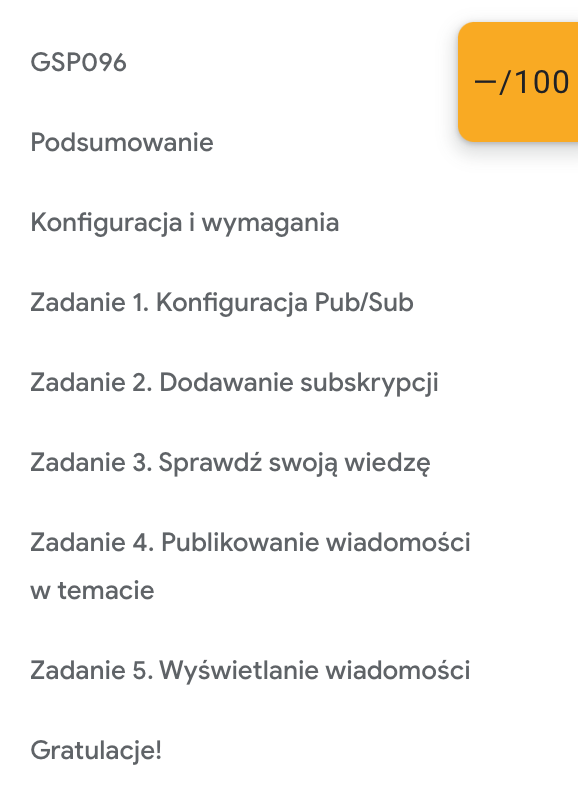

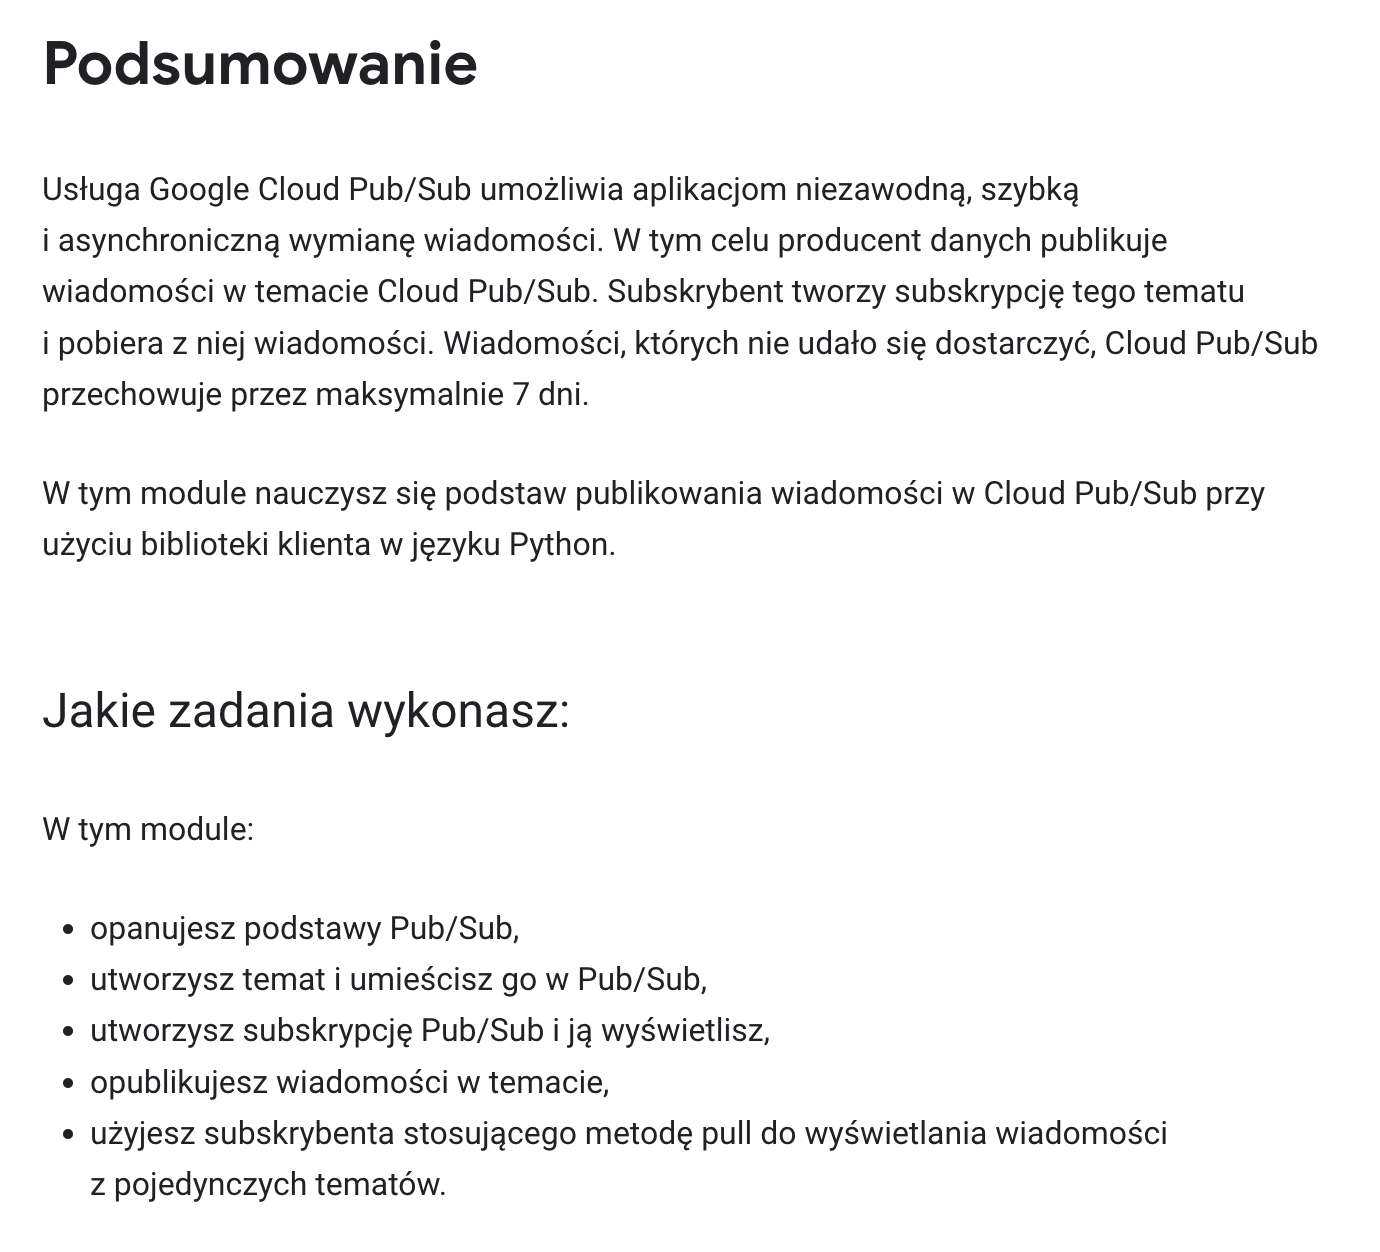

##Zadanie 1. Tworzenie środowiska wirtualnego

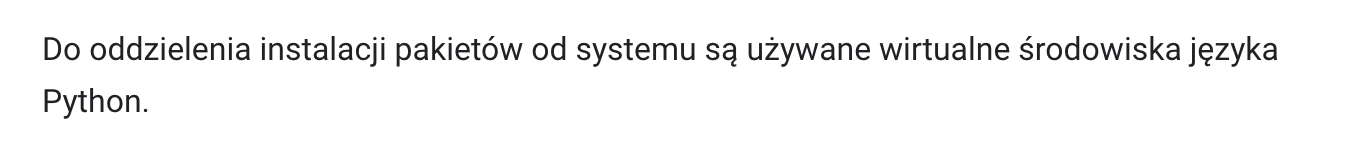

In [ ]:
apt-get install -y virtualenv

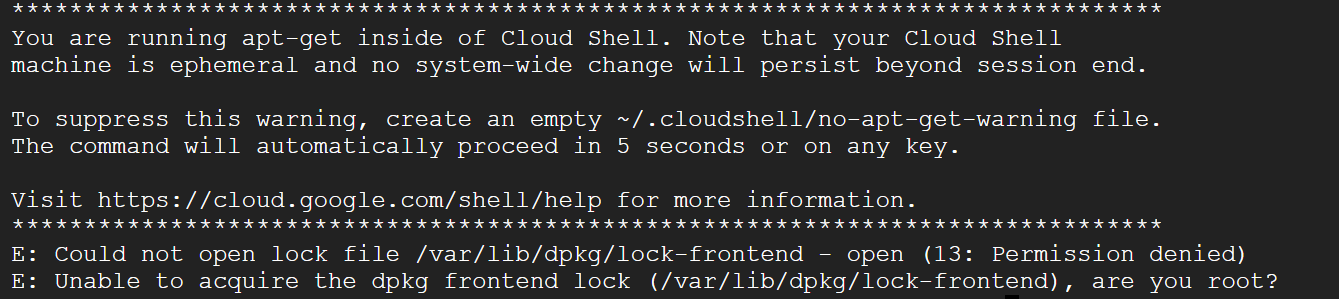

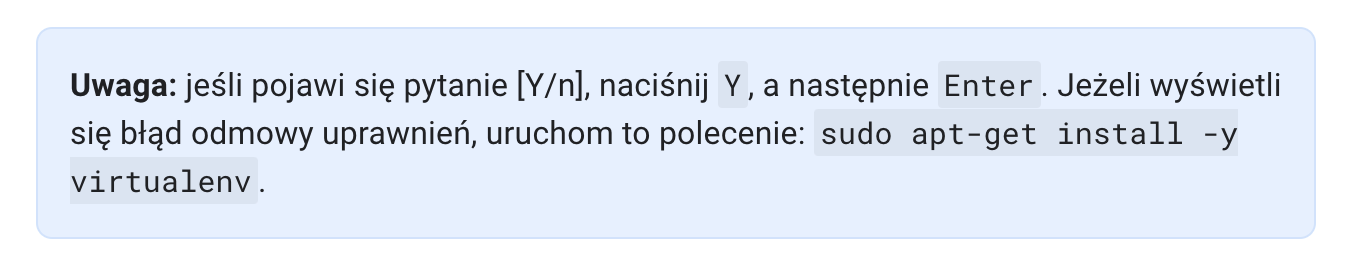

In [ ]:
sudo apt-get install -y virtualenv

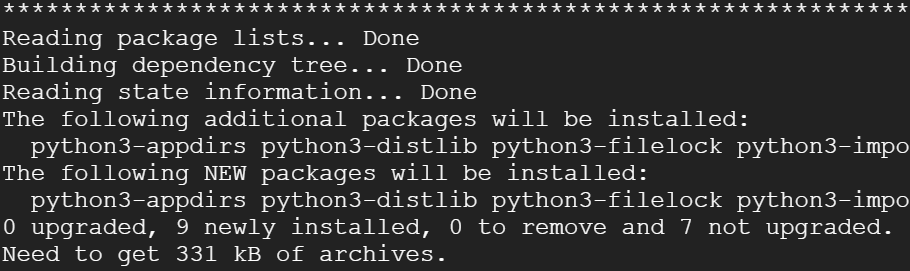

In [ ]:
python3 -m venv venv

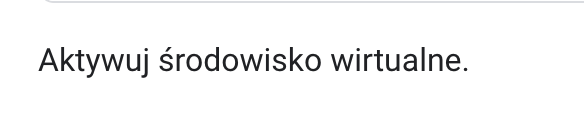

In [ ]:
source venv/bin/activate

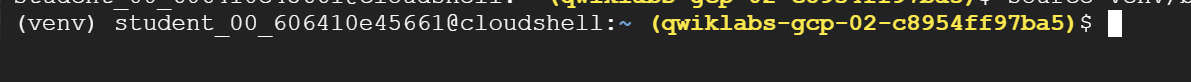

##Zadanie 2. Instalowanie biblioteki klienta

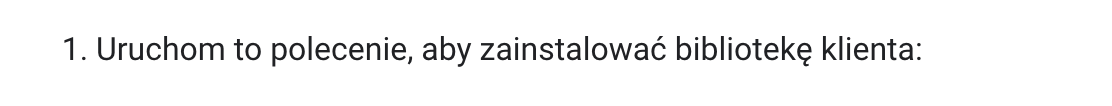

In [ ]:
pip install --upgrade google-cloud-pubsub

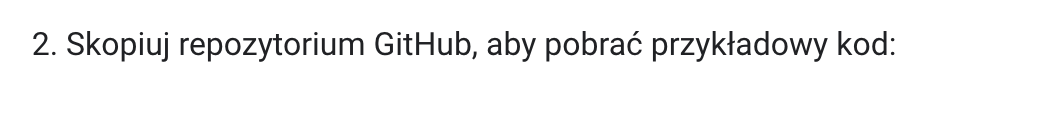

In [ ]:
git clone https://github.com/googleapis/python-pubsub.git

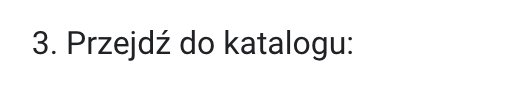

In [ ]:
# https://github.com/googleapis/python-pubsub/tree/main/samples/snippets

In [ ]:
cd python-pubsub/samples/snippets

##Zadanie 3. Pub/Sub – podstawy

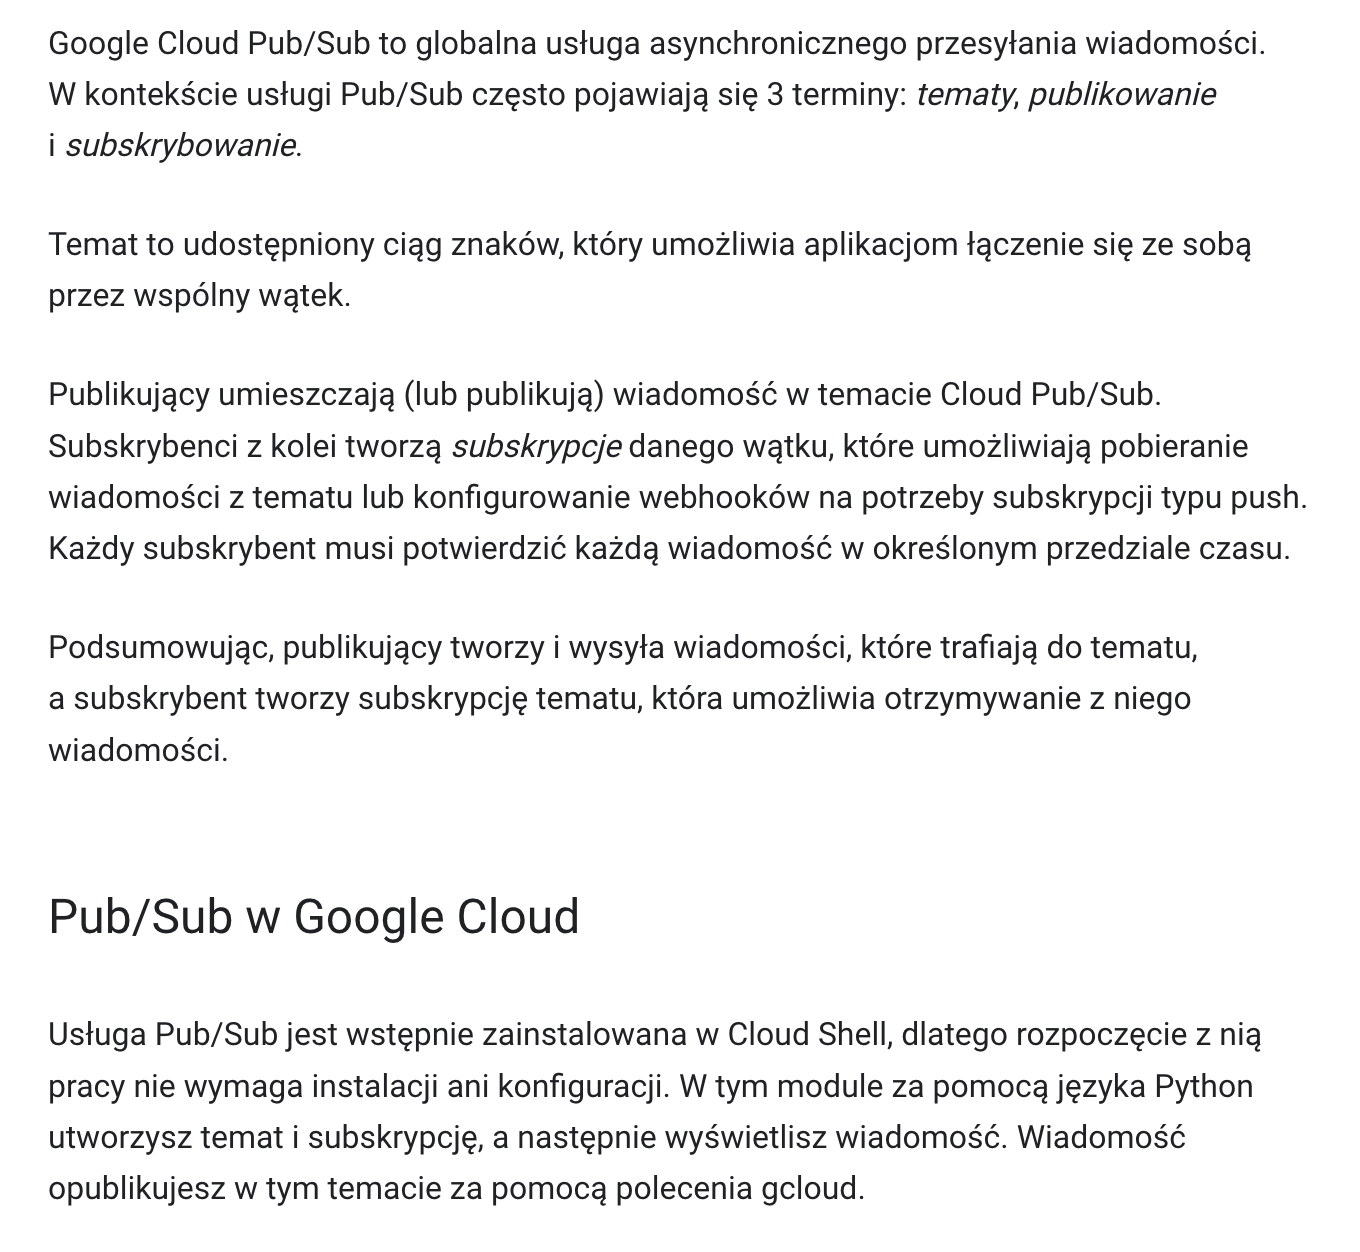

##Zadanie 4. Tworzenie tematu

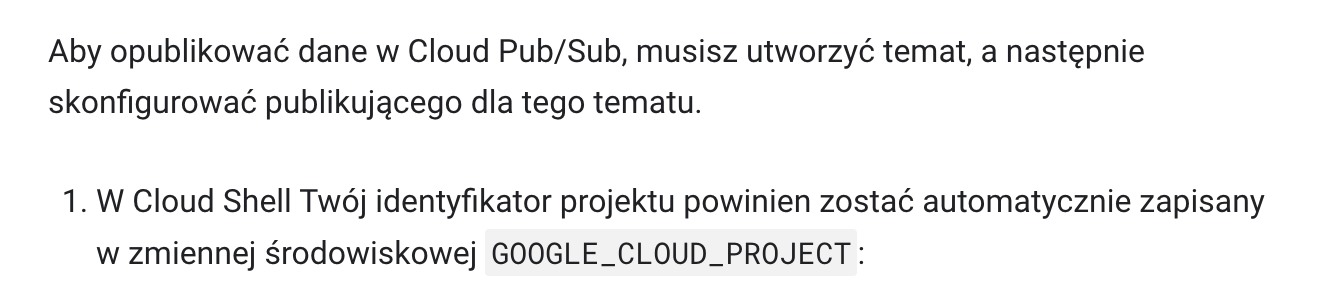

In [ ]:
echo $GOOGLE_CLOUD_PROJECT

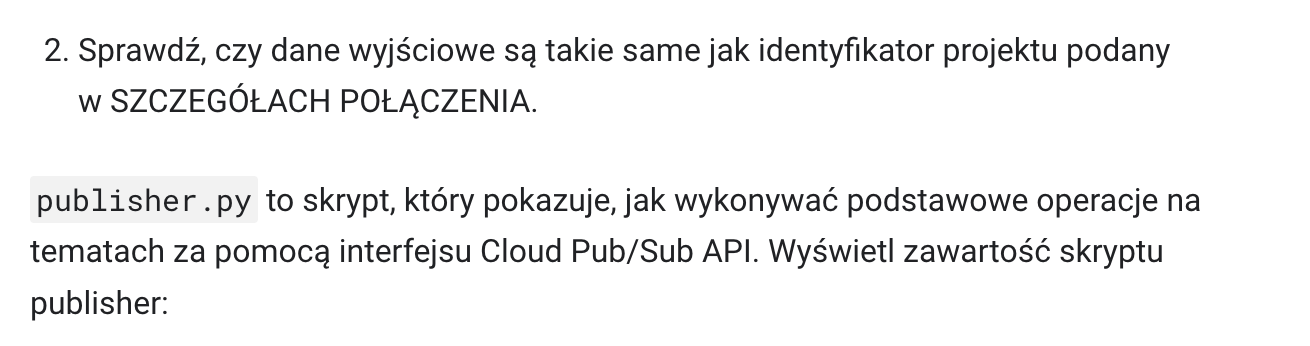

In [ ]:
cat publisher.py

###publisher.py (komentarze)

In [ ]:
#!/usr/bin/env python

# Copyright 2016 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""This application demonstrates how to perform basic operations on topics
with the Cloud Pub/Sub API.
For more information, see the README.md under /pubsub and the documentation
at https://cloud.google.com/pubsub/docs.
"""

import argparse


"""Lista wszystkich tematów w danym projekcie Google Cloud.

Importuje klienta publikującego (PublisherClient) z biblioteki google.cloud.pubsub_v1.
Tworzy obiekt klienta publikującego.
Określa ścieżkę projektu, w tym przypadku "projects/empik-ga360".
Wywołuje metodę list_topics na obiekcie klienta, aby uzyskać listę tematów w projekcie.
Iteruje przez listę tematów i drukuje je."""
def list_topics(project_id: str) -> None:

    from google.cloud import pubsub_v1

    project_id = "empik-ga360"

    publisher = pubsub_v1.PublisherClient()
    project_path = f"projects/{project_id}"

    for topic in publisher.list_topics(request={"project": project_path}):
        print(topic)



# Tworzenie nowego tematu (topic)
def create_topic(project_id: str, topic_id: str) -> None:

    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    # Wywołuje metodę create_topic na obiekcie klienta, aby stworzyć nowy temat w Pub/Sub.
    topic = publisher.create_topic(request={"name": topic_path})

    print(f"Created topic: {topic.name}")




# Usuwanie tematu (topic)
def delete_topic(project_id: str, topic_id: str) -> None:

    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    # Usuwa temat, korzystając z metody delete_topic klienta Pub/Sub.
    publisher.delete_topic(request={"topic": topic_path})

    print(f"Topic deleted: {topic_path}")





# Publikowanie wielu wiadomości w temacie (topic)
def publish_messages(project_id: str, topic_id: str) -> None:

    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    publisher = pubsub_v1.PublisherClient()

    topic_path = publisher.topic_path(project_id, topic_id)

    for n in range(1, 10):
        data_str = f"Message number {n}"

        # Koduje ciąg znaków do formatu bajtowego, co jest wymagane przez API Pub/Sub.
        data = data_str.encode("utf-8")
        future = publisher.publish(topic_path, data)

        # future.result() Blokuje wykonanie do momentu zakończenia publikacji wiadomości.
        print(future.result())

    print(f"Published messages to {topic_path}.")



"""Publikowanie wielu wiadomości w temacie (topic) z dodatkiem niestandardowych atrybutów: origin i username
1. Kategoryzacja i Filtrowanie Wiadomości - Dzięki temu subskrybenci mogą filtrować i przetwarzać tylko te wiadomości,
które są dla nich istotne.
2. Ułatwienie Przetwarzania Wiadomości - Na przykład, mogą one wskazywać format danych lub typ zdarzenia,
co umożliwia odbiorcom lepsze zrozumienie i obsługę otrzymanych danych.
3. Umożliwienie Wielokanałowej Dystrybucji
4. Wzbogacenie Treści Wiadomości"""
def publish_messages_with_custom_attributes(project_id: str, topic_id: str) -> None:

    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    for n in range(1, 10):
        data_str = f"Message number {n}"
        data = data_str.encode("utf-8")
        future = publisher.publish(
            topic_path, data, origin="python-sample", username="gcp"
        )
        print(future.result())

    print(f"Published messages with custom attributes to {topic_path}.")



# Kod ten demonstruje, jak publikować wiadomości do tematu Google Cloud Pub/Sub z obsługą błędów.
def publish_messages_with_error_handler(project_id: str, topic_id: str) -> None:

    from concurrent import futures # Moduł do obsługi asynchronicznych operacji
    from google.cloud import pubsub_v1
    from typing import Callable # Moduł do obsługi typów

    project_id = "empik-ga360"
    topic_id = "topic-b"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    """Inicjuje pustą listę publish_futures, która będzie przechowywać obiekty typu Future
    dla każdej asynchronicznej operacji publikacji."""
    publish_futures = []


"""get_callback to funkcja generująca funkcję callback. Dla każdej publikacji tworzy ona funkcję callback,
która zostanie wywołana, gdy operacja publikacji zakończy się sukcesem lub niepowodzeniem.
Wewnątrz callback sprawdzane jest, czy publikacja się powiodła. W przypadku przekroczenia czasu (timeout),
wyświetlany jest komunikat o błędzie."""
    def get_callback(
        publish_future: pubsub_v1.publisher.futures.Future, data: str
    ) -> Callable[[pubsub_v1.publisher.futures.Future], None]:
        def callback(publish_future: pubsub_v1.publisher.futures.Future) -> None:
            try:
                print(publish_future.result(timeout=60))
            except futures.TimeoutError:
                print(f"Publishing {data} timed out.")

        return callback

"""Publikowanie Wiadomości:
W pętli, dla każdej z 10 wiadomości, tworzy dane do wysłania (data = str(i)), następnie publikuje wiadomość
i rejestruje funkcję callback."""
    for i in range(10):
        data = str(i)

        publish_future = publisher.publish(topic_path, data.encode("utf-8"))
        # Do każdego obiektu Future zwróconego przez operację publikacji dodawany jest callback.
        publish_future.add_done_callback(get_callback(publish_future, data))
        publish_futures.append(publish_future)

    # Blokuje dalsze wykonanie programu, dopóki wszystkie operacje publikacji nie zostaną zakończone.
    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)
    print(f"Published messages with error handler to {topic_path}.")






"""Kod ten demonstruje publikowanie wielu wiadomości do tematu Google Cloud Pub/Sub z wykorzystaniem
ustawień wsadowych (batch settings)"""
def publish_messages_with_batch_settings(project_id: str, topic_id: str) -> None:

    """Importuje moduły futures z pakietu concurrent oraz pubsub_v1 z pakietu google.cloud.
    Te moduły są używane do asynchronicznego wysyłania wiadomości oraz do interakcji z Google Cloud Pub/Sub."""
    from concurrent import futures
    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    # Configure the batch to publish as soon as there are 10 messages
    # or 1 KiB of data, or 1 second has passed.

    """batch_settings = pubsub_v1.types.BatchSettings(...):
    Definiuje ustawienia wsadowe dla klienta publikującego. Ustawienia te kontrolują, jak wiadomości są
    grupowane przed wysłaniem do Pub/Sub:
    max_messages=10: Maksymalna liczba wiadomości w jednym wsadzie.
    max_bytes=1024: Maksymalny rozmiar wsadu w bajtach.
    max_latency=1: Maksymalne opóźnienie w sekundach przed wysłaniem wsadu."""
    batch_settings = pubsub_v1.types.BatchSettings(
        max_messages=10,  # default 100
        max_bytes=1024,  # default 1 MB
        max_latency=1,  # default 10 ms
    )

    """Tworzenie Klienta Pub/Sub:
    publisher = pubsub_v1.PublisherClient(batch_settings): Tworzy obiekt klienta publikującego
    z określonymi ustawieniami wsadowymi."""
    publisher = pubsub_v1.PublisherClient(batch_settings)

    """Określenie Ścieżki Tematu:
    topic_path = publisher.topic_path(project_id, topic_id): Tworzy ścieżkę do tematu,
    na który będą wysyłane wiadomości."""
    topic_path = publisher.topic_path(project_id, topic_id)
    publish_futures = []

    """Funkcja Zwrotna Callback:
    def callback(future: pubsub_v1.publisher.futures.Future): Funkcja zwrotna, która jest wywoływana,
    gdy operacja publikacji zostanie zakończona. Wydrukowuje identyfikator wiadomości (message_id)
    uzyskany z future.result()."""
    def callback(future: pubsub_v1.publisher.futures.Future) -> None:
        message_id = future.result()
        print(message_id)

    """Publikowanie Wiadomości:
    W pętli for n in range(1, 10):, tworzy i koduje dane do wysłania, a następnie wysyła je do Pub/Sub.
    Każda operacja publikacji zwraca obiekt Future.
    publish_future.add_done_callback(callback): Rejestruje funkcję zwrotną callback dla każdej operacji publikacji.
    publish_futures.append(publish_future): Dodaje obiekt Future do listy publish_futures."""
    for n in range(1, 10):
        data_str = f"Message number {n}"
        data = data_str.encode("utf-8")
        publish_future = publisher.publish(topic_path, data)
        publish_future.add_done_callback(callback)
        publish_futures.append(publish_future)

    """Oczekiwanie na Zakończenie Operacji Publikacji:
    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED): Czeka, aż wszystkie operacje
    publikacji zostaną zakończone."""
    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)
    print(f"Published messages with batch settings to {topic_path}.")




"""Kod ten demonstruje sposób publikowania wiadomości do tematu Google Cloud Pub/Sub z użyciem ustawień
kontroli przepływu (flow control settings). Jest to przydatne w przypadkach, gdy chcesz uniknąć zbytniego
obciążenia klienta Pub/Sub dużą liczbą wiadomości."""
def publish_messages_with_flow_control_settings(project_id: str, topic_id: str) -> None:

    """Importowanie Niezbędnych Bibliotek:
    Importuje moduły niezbędne do pracy z Google Cloud Pub/Sub i obsługi asynchronicznych operacji."""
    from concurrent import futures
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import (
        LimitExceededBehavior,
        PublisherOptions,
        PublishFlowControl,
    )

    project_id = "empik-ga360"
    topic_id = "topic-b"

    """Ustawienia Kontroli Przepływu:
    PublishFlowControl(...): Definiuje ustawienia kontroli przepływu dla klienta publikującego.
    Ustawienia te kontrolują, ile wiadomości lub jaka ilość danych może być przechowywana w pamięci
    przed ich wysłaniem:
    message_limit=100: Maksymalna liczba wiadomości przechowywana w pamięci.
    byte_limit=10 * 1024 * 1024: Maksymalny rozmiar danych przechowywanych w pamięci (10 MiB).
    limit_exceeded_behavior=LimitExceededBehavior.BLOCK: Zachowanie w przypadku przekroczenia limitu
    (blokowanie wysyłania nowych wiadomości do momentu zwolnienia miejsca)."""
    flow_control_settings = PublishFlowControl(
        message_limit=100,  # 100 messages
        byte_limit=10 * 1024 * 1024,  # 10 MiB
        limit_exceeded_behavior=LimitExceededBehavior.BLOCK,
    )

    """Tworzenie Klienta Pub/Sub z Ustawieniami Kontroli Przepływu:
    PublisherClient(publisher_options=PublisherOptions(...)): Tworzy klienta Pub/Sub ze zdefiniowanymi
    ustawieniami kontroli przepływu."""
    publisher = pubsub_v1.PublisherClient(
        publisher_options=PublisherOptions(flow_control=flow_control_settings)
    )

    """Określenie Ścieżki Tematu:
    topic_path = publisher.topic_path(project_id, topic_id): Ustala ścieżkę do tematu."""
    topic_path = publisher.topic_path(project_id, topic_id)
    publish_futures = []

    """Funkcja Zwrotna Callback:
    def callback(...): Funkcja zwrotna, która jest wywoływana po zakończeniu operacji publikacji.
    Wydrukowuje identyfikator wiadomości."""
    def callback(publish_future: pubsub_v1.publisher.futures.Future) -> None:
        message_id = publish_future.result()
        print(message_id)

    """Publikowanie Wiadomości:
    W pętli, tworzy i koduje dane do wysłania, a następnie publikuje wiadomości do Pub/Sub.
    Każda operacja publikacji zwraca obiekt Future.

    publish_future.add_done_callback(callback): Rejestruje funkcję zwrotną callback dla każdej operacji publikacji.
    publish_futures.append(publish_future): Dodaje obiekt Future do listy."""
    for n in range(1, 1000):
        data_str = f"Message number {n}"
        data = data_str.encode("utf-8")
        publish_future = publisher.publish(topic_path, data)
        publish_future.add_done_callback(callback)
        publish_futures.append(publish_future)

    """Oczekiwanie na Zakończenie Operacji Publikacji:
    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED): Czeka, aż wszystkie operacje publikacji
    zostaną zakończone."""
    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)

    print(f"Published messages with flow control settings to {topic_path}.")





"""Kod ten ilustruje publikowanie wiadomości do tematu Google Cloud Pub/Sub z niestandardowymi
ustawieniami ponawiania prób (retry settings)."""
def publish_messages_with_retry_settings(project_id: str, topic_id: str) -> None:

    """Kod importuje potrzebne moduły z pakietów google.cloud i google.api_core.
    Te moduły są wykorzystywane do interakcji z usługą Google Cloud Pub/Sub oraz do konfiguracji
    zachowania przy ponawianiu prób."""
    from google import api_core
    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    """Konfiguracja Ustawień Ponawiania Prób:
    api_core.retry.Retry(...): Tworzy niestandardowy obiekt Retry do kontrolowania zachowania przy ponawianiu prób.
    Parametry takie jak initial, maximum, multiplier i deadline określają, jak często i jak długo powinny
    być ponawiane próby w przypadku wystąpienia błędów.

    predicate=api_core.retry.if_exception_type(...): Określa typy wyjątków, które spowodują ponowienie próby.
    W tym przypadku obejmuje to różne typy błędów sieciowych i serwerowych."""
    custom_retry = api_core.retry.Retry(
        initial=0.250,  # seconds (default: 0.1)
        maximum=90.0,  # seconds (default: 60.0)
        multiplier=1.45,  # default: 1.3
        deadline=300.0,  # seconds (default: 60.0)
        predicate=api_core.retry.if_exception_type(
            api_core.exceptions.Aborted,
            api_core.exceptions.DeadlineExceeded,
            api_core.exceptions.InternalServerError,
            api_core.exceptions.ResourceExhausted,
            api_core.exceptions.ServiceUnavailable,
            api_core.exceptions.Unknown,
            api_core.exceptions.Cancelled,
        ),
    )

    """Tworzenie Klienta Pub/Sub i Ścieżki Tematu:
    Tworzy klienta Pub/Sub i ustala ścieżkę do tematu, na który będą publikowane wiadomości."""
    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    """Publikowanie Wiadomości z Ustawieniami Ponawiania Prób:
    W pętli for n in range(1, 10):, kod tworzy serię wiadomości do publikacji. Każda wiadomość jest zakodowana
    do formatu bajtowego.
    publisher.publish(...): Wywołanie metody publikacji z dodatkowym argumentem retry=custom_retry,
    co oznacza, że w przypadku błędów publikacja będzie ponawiana zgodnie z niestandardowymi ustawieniami.
    print(future.result()): Drukuje wynik publikacji (lub błąd) po zakończeniu operacji."""
    for n in range(1, 10):
        data_str = f"Message number {n}"
        data = data_str.encode("utf-8")
        future = publisher.publish(topic=topic_path, data=data, retry=custom_retry)
        print(future.result())

    print(f"Published messages with retry settings to {topic_path}.")






"""Kod ten ilustruje sposób publikowania wiadomości do tematu Google Cloud Pub/Sub z wykorzystaniem
kluczy uporządkowania (ordering keys). Klucze uporządkowania zapewniają, że wiadomości są dostarczane
w kolejności, w jakiej zostały opublikowane, w ramach tego samego klucza."""
def publish_with_ordering_keys(project_id: str, topic_id: str) -> None:

    # Importuje moduł pubsub_v1, który jest używany do interakcji z Google Cloud Pub/Sub.
    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    """Konfiguracja Opcji Publikacji:
    PublisherOptions(enable_message_ordering=True): Konfiguruje opcje publikacji, włączając uporządkowanie
    wiadomości, co jest kluczowe do zachowania kolejności wiadomości.
    client_options: Ustawia opcje klienta, w tym punkt końcowy API, który może być używany do optymalizacji
    wydajności, zwłaszcza przy komunikacji w ramach tego samego regionu."""
    publisher_options = pubsub_v1.types.PublisherOptions(enable_message_ordering=True)
    client_options = {"api_endpoint": "us-east1-pubsub.googleapis.com:443"}

    """Tworzy obiekt klienta PublisherClient z zdefiniowanymi opcjami."""
    publisher = pubsub_v1.PublisherClient(
        publisher_options=publisher_options, client_options=client_options
    )

    # Ustala pełną ścieżkę do tematu Pub/Sub, na który będą wysyłane wiadomości.
    topic_path = publisher.topic_path(project_id, topic_id)

    """Publikowanie Wiadomości z Kluczami Uporządkowania:
    Iteruje przez listę wiadomości zdefiniowanych jako pary (dane, klucz uporządkowania).
    Każda wiadomość jest zakodowana do formatu bajtowego.
    Dla każdej wiadomości używa metody publisher.publish do publikacji, przekazując dane i klucz uporządkowania.
    ordering_key: Klucz uporządkowania, który zapewnia, że wiadomości z tym samym kluczem są dostarczane
    w kolejności, w jakiej zostały opublikowane."""
    for message in [
        ("message1", "key1"),
        ("message2", "key2"),
        ("message3", "key1"),
        ("message4", "key2"),
    ]:
        data = message[0].encode("utf-8")
        ordering_key = message[1]
        future = publisher.publish(topic_path, data=data, ordering_key=ordering_key)
        print(future.result())

    print(f"Published messages with ordering keys to {topic_path}.")





"""Kod ten demonstruje sposób publikowania wiadomości do tematu Google Cloud Pub/Sub z wykorzystaniem
kluczy uporządkowania, wraz z obsługą sytuacji, gdy występują nieodwracalne błędy.
Klucze uporządkowania zapewniają, że wiadomości są dostarczane w kolejności, w jakiej
zostały opublikowane, w ramach tego samego klucza."""
def resume_publish_with_ordering_keys(project_id: str, topic_id: str) -> None:
    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    topic_id = "topic-b"

    """Konfiguracja Opcji Publikacji:
    PublisherOptions(enable_message_ordering=True): Włącza uporządkowanie wiadomości, co jest kluczowe
    do zachowania kolejności wiadomości dla danego klucza uporządkowania.
    client_options: Ustawia opcje klienta, w tym punkt końcowy API, co może być używane do
    optymalizacji wydajności."""
    publisher_options = pubsub_v1.types.PublisherOptions(enable_message_ordering=True)
    client_options = {"api_endpoint": "us-east1-pubsub.googleapis.com:443"}


    # Inicjuje klienta Pub/Sub z powyższymi opcjami.
    publisher = pubsub_v1.PublisherClient(
        publisher_options=publisher_options, client_options=client_options
    )
    # Ustala pełną ścieżkę do tematu Pub/Sub, na który będą wysyłane wiadomości.
    topic_path = publisher.topic_path(project_id, topic_id)


    """Publikowanie Wiadomości z Kluczami Uporządkowania i Obsługa Błędów:
    Iteruje przez listę wiadomości zdefiniowanych jako pary (dane, klucz uporządkowania).
    Każda wiadomość jest zakodowana do formatu bajtowego.
    Dla każdej wiadomości używa metody publisher.publish do publikacji, przekazując dane i klucz uporządkowania.
    W przypadku wystąpienia RuntimeError (co może wskazywać na nieodwracalny błąd), wywoływana
    jest metoda publisher.resume_publish dla danego klucza uporządkowania, aby wznowić publikowanie
    wiadomości dla tego klucza."""
    for message in [
        ("message1", "key1"),
        ("message2", "key2"),
        ("message3", "key1"),
        ("message4", "key2"),
    ]:

        data = message[0].encode("utf-8")
        ordering_key = message[1]
        future = publisher.publish(topic_path, data=data, ordering_key=ordering_key)
        try:
            print(future.result())
        except RuntimeError:
            publisher.resume_publish(topic_path, ordering_key)

    print(f"Resumed publishing messages with ordering keys to {topic_path}.")



"""Kod ten ilustruje sposób odłączania subskrypcji od tematu w Google Cloud Pub/Sub i
usuwania wszystkich wiadomości, które zostały w niej zatrzymane."""
def detach_subscription(project_id: str, subscription_id: str) -> None:

    """Kod importuje potrzebne moduły z pakietu google.cloud i google.api_core. Są one wykorzystywane do
    interakcji z Google Cloud Pub/Sub i obsługi wyjątków."""
    from google.api_core.exceptions import GoogleAPICallError, RetryError
    from google.cloud import pubsub_v1

    project_id = "empik-ga360"
    subscription_id = "your-subscription-id"

    """Tworzenie Klientów Pub/Sub:
    Inicjuje dwa klienty Pub/Sub: PublisherClient i SubscriberClient.
    PublisherClient jest używany do operacji na tematach,
    a SubscriberClient do operacji na subskrypcjach."""
    publisher_client = pubsub_v1.PublisherClient()
    subscriber_client = pubsub_v1.SubscriberClient()

    """Tworzy ścieżkę subskrypcji, korzystając z subscriber_client.subscription_path, wykorzystując podane
    project_id i subscription_id."""
    subscription_path = subscriber_client.subscription_path(project_id, subscription_id)

    """Odłączanie Subskrypcji:
    publisher_client.detach_subscription(...): Próbuje odłączyć subskrypcję od tematu.
    Jeśli subskrypcja jest odłączona, wszystkie wiadomości zatrzymane w tej subskrypcji są usuwane.
    Obsługa wyjątków: Jeśli wystąpi błąd podczas odłączania subskrypcji, kod próbuje go przechwycić
    i wydrukować."""
    try:
        publisher_client.detach_subscription(
            request={"subscription": subscription_path}
        )
    except (GoogleAPICallError, RetryError, ValueError, Exception) as err:
        print(err)

    """Sprawdzanie Stanu Subskrypcji:
    Po próbie odłączenia, kod sprawdza, czy subskrypcja została faktycznie odłączona, wykonując
    subscriber_client.get_subscription(...).
    W zależności od stanu subscription.detached, drukuje odpowiednią wiadomość informującą o tym,
    czy subskrypcja została odłączona."""
    subscription = subscriber_client.get_subscription(
        request={"subscription": subscription_path}
    )
    if subscription.detached:
        print(f"{subscription_path} is detached.")
    else:
        print(f"{subscription_path} is NOT detached.")





if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter,
    )
    parser.add_argument("project_id", help="Your Google Cloud project ID")

    subparsers = parser.add_subparsers(dest="command")
    subparsers.add_parser("list", help=list_topics.__doc__)

    create_parser = subparsers.add_parser("create", help=create_topic.__doc__)
    create_parser.add_argument("topic_id")

    delete_parser = subparsers.add_parser("delete", help=delete_topic.__doc__)
    delete_parser.add_argument("topic_id")

    publish_parser = subparsers.add_parser("publish", help=publish_messages.__doc__)
    publish_parser.add_argument("topic_id")

    publish_with_custom_attributes_parser = subparsers.add_parser(
        "publish-with-custom-attributes",
        help=publish_messages_with_custom_attributes.__doc__,
    )
    publish_with_custom_attributes_parser.add_argument("topic_id")

    publish_with_error_handler_parser = subparsers.add_parser(
        "publish-with-error-handler",
        help=publish_messages_with_error_handler.__doc__,
    )
    publish_with_error_handler_parser.add_argument("topic_id")

    publish_with_batch_settings_parser = subparsers.add_parser(
        "publish-with-batch-settings",
        help=publish_messages_with_batch_settings.__doc__,
    )
    publish_with_batch_settings_parser.add_argument("topic_id")

    publish_with_flow_control_settings_parser = subparsers.add_parser(
        "publish-with-flow-control",
        help=publish_messages_with_flow_control_settings.__doc__,
    )
    publish_with_flow_control_settings_parser.add_argument("topic_id")

    publish_with_retry_settings_parser = subparsers.add_parser(
        "publish-with-retry-settings",
        help=publish_messages_with_retry_settings.__doc__,
    )
    publish_with_retry_settings_parser.add_argument("topic_id")

    publish_with_ordering_keys_parser = subparsers.add_parser(
        "publish-with-ordering-keys",
        help=publish_with_ordering_keys.__doc__,
    )
    publish_with_ordering_keys_parser.add_argument("topic_id")

    resume_publish_with_ordering_keys_parser = subparsers.add_parser(
        "resume-publish-with-ordering-keys",
        help=resume_publish_with_ordering_keys.__doc__,
    )
    resume_publish_with_ordering_keys_parser.add_argument("topic_id")

    detach_subscription_parser = subparsers.add_parser(
        "detach-subscription",
        help=detach_subscription.__doc__,
    )
    detach_subscription_parser.add_argument("subscription_id")

    args = parser.parse_args()

    if args.command == "list":
        list_topics(args.project_id)
    elif args.command == "create":
        create_topic(args.project_id, args.topic_id)
    elif args.command == "delete":
        delete_topic(args.project_id, args.topic_id)
    elif args.command == "publish":
        publish_messages(args.project_id, args.topic_id)
    elif args.command == "publish-with-custom-attributes":
        publish_messages_with_custom_attributes(args.project_id, args.topic_id)
    elif args.command == "publish-with-error-handler":
        publish_messages_with_error_handler(args.project_id, args.topic_id)
    elif args.command == "publish-with-batch-settings":
        publish_messages_with_batch_settings(args.project_id, args.topic_id)
    elif args.command == "publish-with-flow-control":
        publish_messages_with_flow_control_settings(args.project_id, args.topic_id)
    elif args.command == "publish-with-retry-settings":
        publish_messages_with_retry_settings(args.project_id, args.topic_id)
    elif args.command == "publish-with-ordering-keys":
        publish_with_ordering_keys(args.project_id, args.topic_id)
    elif args.command == "resume-publish-with-ordering-keys":
        resume_publish_with_ordering_keys(args.project_id, args.topic_id)
    elif args.command == "detach-subscription":
        detach_subscription(args.project_id, args.subscription_id)

###publisher.py

In [ ]:
#!/usr/bin/env python

# Copyright 2016 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""This application demonstrates how to perform basic operations on topics
with the Cloud Pub/Sub API.
For more information, see the README.md under /pubsub and the documentation
at https://cloud.google.com/pubsub/docs.
"""

import argparse


def list_topics(project_id: str) -> None:
    """Lists all Pub/Sub topics in the given project."""
    # [START pubsub_list_topics]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"

    publisher = pubsub_v1.PublisherClient()
    project_path = f"projects/{project_id}"

    for topic in publisher.list_topics(request={"project": project_path}):
        print(topic)
    # [END pubsub_list_topics]


def create_topic(project_id: str, topic_id: str) -> None:
    """Create a new Pub/Sub topic."""
    # [START pubsub_quickstart_create_topic]
    # [START pubsub_create_topic]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    topic = publisher.create_topic(request={"name": topic_path})

    print(f"Created topic: {topic.name}")
    # [END pubsub_quickstart_create_topic]
    # [END pubsub_create_topic]


def delete_topic(project_id: str, topic_id: str) -> None:
    """Deletes an existing Pub/Sub topic."""
    # [START pubsub_delete_topic]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    publisher.delete_topic(request={"topic": topic_path})

    print(f"Topic deleted: {topic_path}")
    # [END pubsub_delete_topic]


def publish_messages(project_id: str, topic_id: str) -> None:
    """Publishes multiple messages to a Pub/Sub topic."""
    # [START pubsub_quickstart_publisher]
    # [START pubsub_publish]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher = pubsub_v1.PublisherClient()
    # The `topic_path` method creates a fully qualified identifier
    # in the form `projects/{project_id}/topics/{topic_id}`
    topic_path = publisher.topic_path(project_id, topic_id)

    for n in range(1, 10):
        data_str = f"Message number {n}"
        # Data must be a bytestring
        data = data_str.encode("utf-8")
        # When you publish a message, the client returns a future.
        future = publisher.publish(topic_path, data)
        print(future.result())

    print(f"Published messages to {topic_path}.")
    # [END pubsub_quickstart_publisher]
    # [END pubsub_publish]


def publish_messages_with_custom_attributes(project_id: str, topic_id: str) -> None:
    """Publishes multiple messages with custom attributes
    to a Pub/Sub topic."""
    # [START pubsub_publish_custom_attributes]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    for n in range(1, 10):
        data_str = f"Message number {n}"
        # Data must be a bytestring
        data = data_str.encode("utf-8")
        # Add two attributes, origin and username, to the message
        future = publisher.publish(
            topic_path, data, origin="python-sample", username="gcp"
        )
        print(future.result())

    print(f"Published messages with custom attributes to {topic_path}.")
    # [END pubsub_publish_custom_attributes]


def publish_messages_with_error_handler(project_id: str, topic_id: str) -> None:
    # [START pubsub_publish_with_error_handler]
    """Publishes multiple messages to a Pub/Sub topic with an error handler."""
    from concurrent import futures
    from google.cloud import pubsub_v1
    from typing import Callable

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    publish_futures = []

    def get_callback(
        publish_future: pubsub_v1.publisher.futures.Future, data: str
    ) -> Callable[[pubsub_v1.publisher.futures.Future], None]:
        def callback(publish_future: pubsub_v1.publisher.futures.Future) -> None:
            try:
                # Wait 60 seconds for the publish call to succeed.
                print(publish_future.result(timeout=60))
            except futures.TimeoutError:
                print(f"Publishing {data} timed out.")

        return callback

    for i in range(10):
        data = str(i)
        # When you publish a message, the client returns a future.
        publish_future = publisher.publish(topic_path, data.encode("utf-8"))
        # Non-blocking. Publish failures are handled in the callback function.
        publish_future.add_done_callback(get_callback(publish_future, data))
        publish_futures.append(publish_future)

    # Wait for all the publish futures to resolve before exiting.
    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)

    print(f"Published messages with error handler to {topic_path}.")
    # [END pubsub_publish_with_error_handler]


def publish_messages_with_batch_settings(project_id: str, topic_id: str) -> None:
    """Publishes multiple messages to a Pub/Sub topic with batch settings."""
    # [START pubsub_publisher_batch_settings]
    from concurrent import futures
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    # Configure the batch to publish as soon as there are 10 messages
    # or 1 KiB of data, or 1 second has passed.
    batch_settings = pubsub_v1.types.BatchSettings(
        max_messages=10,  # default 100
        max_bytes=1024,  # default 1 MB
        max_latency=1,  # default 10 ms
    )
    publisher = pubsub_v1.PublisherClient(batch_settings)
    topic_path = publisher.topic_path(project_id, topic_id)
    publish_futures = []

    # Resolve the publish future in a separate thread.
    def callback(future: pubsub_v1.publisher.futures.Future) -> None:
        message_id = future.result()
        print(message_id)

    for n in range(1, 10):
        data_str = f"Message number {n}"
        # Data must be a bytestring
        data = data_str.encode("utf-8")
        publish_future = publisher.publish(topic_path, data)
        # Non-blocking. Allow the publisher client to batch multiple messages.
        publish_future.add_done_callback(callback)
        publish_futures.append(publish_future)

    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)

    print(f"Published messages with batch settings to {topic_path}.")
    # [END pubsub_publisher_batch_settings]


def publish_messages_with_flow_control_settings(project_id: str, topic_id: str) -> None:
    """Publishes messages to a Pub/Sub topic with flow control settings."""
    # [START pubsub_publisher_flow_control]
    from concurrent import futures
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import (
        LimitExceededBehavior,
        PublisherOptions,
        PublishFlowControl,
    )

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    # Configure how many messages the publisher client can hold in memory
    # and what to do when messages exceed the limit.
    flow_control_settings = PublishFlowControl(
        message_limit=100,  # 100 messages
        byte_limit=10 * 1024 * 1024,  # 10 MiB
        limit_exceeded_behavior=LimitExceededBehavior.BLOCK,
    )
    publisher = pubsub_v1.PublisherClient(
        publisher_options=PublisherOptions(flow_control=flow_control_settings)
    )
    topic_path = publisher.topic_path(project_id, topic_id)
    publish_futures = []

    # Resolve the publish future in a separate thread.
    def callback(publish_future: pubsub_v1.publisher.futures.Future) -> None:
        message_id = publish_future.result()
        print(message_id)

    # Publish 1000 messages in quick succession may be constrained by
    # publisher flow control.
    for n in range(1, 1000):
        data_str = f"Message number {n}"
        # Data must be a bytestring
        data = data_str.encode("utf-8")
        publish_future = publisher.publish(topic_path, data)
        # Non-blocking. Allow the publisher client to batch messages.
        publish_future.add_done_callback(callback)
        publish_futures.append(publish_future)

    futures.wait(publish_futures, return_when=futures.ALL_COMPLETED)

    print(f"Published messages with flow control settings to {topic_path}.")
    # [END pubsub_publisher_flow_control]


def publish_messages_with_retry_settings(project_id: str, topic_id: str) -> None:
    """Publishes messages with custom retry settings."""
    # [START pubsub_publisher_retry_settings]
    from google import api_core
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    # Configure the retry settings. Defaults shown in comments are values applied
    # by the library by default, instead of default values in the Retry object.
    custom_retry = api_core.retry.Retry(
        initial=0.250,  # seconds (default: 0.1)
        maximum=90.0,  # seconds (default: 60.0)
        multiplier=1.45,  # default: 1.3
        deadline=300.0,  # seconds (default: 60.0)
        predicate=api_core.retry.if_exception_type(
            api_core.exceptions.Aborted,
            api_core.exceptions.DeadlineExceeded,
            api_core.exceptions.InternalServerError,
            api_core.exceptions.ResourceExhausted,
            api_core.exceptions.ServiceUnavailable,
            api_core.exceptions.Unknown,
            api_core.exceptions.Cancelled,
        ),
    )

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    for n in range(1, 10):
        data_str = f"Message number {n}"
        # Data must be a bytestring
        data = data_str.encode("utf-8")
        future = publisher.publish(topic=topic_path, data=data, retry=custom_retry)
        print(future.result())

    print(f"Published messages with retry settings to {topic_path}.")
    # [END pubsub_publisher_retry_settings]


def publish_with_ordering_keys(project_id: str, topic_id: str) -> None:
    """Publishes messages with ordering keys."""
    # [START pubsub_publish_with_ordering_keys]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher_options = pubsub_v1.types.PublisherOptions(enable_message_ordering=True)
    # Sending messages to the same region ensures they are received in order
    # even when multiple publishers are used.
    client_options = {"api_endpoint": "us-east1-pubsub.googleapis.com:443"}
    publisher = pubsub_v1.PublisherClient(
        publisher_options=publisher_options, client_options=client_options
    )
    # The `topic_path` method creates a fully qualified identifier
    # in the form `projects/{project_id}/topics/{topic_id}`
    topic_path = publisher.topic_path(project_id, topic_id)

    for message in [
        ("message1", "key1"),
        ("message2", "key2"),
        ("message3", "key1"),
        ("message4", "key2"),
    ]:
        # Data must be a bytestring
        data = message[0].encode("utf-8")
        ordering_key = message[1]
        # When you publish a message, the client returns a future.
        future = publisher.publish(topic_path, data=data, ordering_key=ordering_key)
        print(future.result())

    print(f"Published messages with ordering keys to {topic_path}.")
    # [END pubsub_publish_with_ordering_keys]


def resume_publish_with_ordering_keys(project_id: str, topic_id: str) -> None:
    """Resume publishing messages with ordering keys when unrecoverable errors occur."""
    # [START pubsub_resume_publish_with_ordering_keys]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher_options = pubsub_v1.types.PublisherOptions(enable_message_ordering=True)
    # Sending messages to the same region ensures they are received in order
    # even when multiple publishers are used.
    client_options = {"api_endpoint": "us-east1-pubsub.googleapis.com:443"}
    publisher = pubsub_v1.PublisherClient(
        publisher_options=publisher_options, client_options=client_options
    )
    # The `topic_path` method creates a fully qualified identifier
    # in the form `projects/{project_id}/topics/{topic_id}`
    topic_path = publisher.topic_path(project_id, topic_id)

    for message in [
        ("message1", "key1"),
        ("message2", "key2"),
        ("message3", "key1"),
        ("message4", "key2"),
    ]:
        # Data must be a bytestring
        data = message[0].encode("utf-8")
        ordering_key = message[1]
        # When you publish a message, the client returns a future.
        future = publisher.publish(topic_path, data=data, ordering_key=ordering_key)
        try:
            print(future.result())
        except RuntimeError:
            # Resume publish on an ordering key that has had unrecoverable errors.
            publisher.resume_publish(topic_path, ordering_key)

    print(f"Resumed publishing messages with ordering keys to {topic_path}.")
    # [END pubsub_resume_publish_with_ordering_keys]


def detach_subscription(project_id: str, subscription_id: str) -> None:
    """Detaches a subscription from a topic and drops all messages retained in it."""
    # [START pubsub_detach_subscription]
    from google.api_core.exceptions import GoogleAPICallError, RetryError
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing subscription.
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    publisher_client = pubsub_v1.PublisherClient()
    subscriber_client = pubsub_v1.SubscriberClient()
    subscription_path = subscriber_client.subscription_path(project_id, subscription_id)

    try:
        publisher_client.detach_subscription(
            request={"subscription": subscription_path}
        )
    except (GoogleAPICallError, RetryError, ValueError, Exception) as err:
        print(err)

    subscription = subscriber_client.get_subscription(
        request={"subscription": subscription_path}
    )
    if subscription.detached:
        print(f"{subscription_path} is detached.")
    else:
        print(f"{subscription_path} is NOT detached.")
    # [END pubsub_detach_subscription]


if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter,
    )
    parser.add_argument("project_id", help="Your Google Cloud project ID")

    subparsers = parser.add_subparsers(dest="command")
    subparsers.add_parser("list", help=list_topics.__doc__)

    create_parser = subparsers.add_parser("create", help=create_topic.__doc__)
    create_parser.add_argument("topic_id")

    delete_parser = subparsers.add_parser("delete", help=delete_topic.__doc__)
    delete_parser.add_argument("topic_id")

    publish_parser = subparsers.add_parser("publish", help=publish_messages.__doc__)
    publish_parser.add_argument("topic_id")

    publish_with_custom_attributes_parser = subparsers.add_parser(
        "publish-with-custom-attributes",
        help=publish_messages_with_custom_attributes.__doc__,
    )
    publish_with_custom_attributes_parser.add_argument("topic_id")

    publish_with_error_handler_parser = subparsers.add_parser(
        "publish-with-error-handler",
        help=publish_messages_with_error_handler.__doc__,
    )
    publish_with_error_handler_parser.add_argument("topic_id")

    publish_with_batch_settings_parser = subparsers.add_parser(
        "publish-with-batch-settings",
        help=publish_messages_with_batch_settings.__doc__,
    )
    publish_with_batch_settings_parser.add_argument("topic_id")

    publish_with_flow_control_settings_parser = subparsers.add_parser(
        "publish-with-flow-control",
        help=publish_messages_with_flow_control_settings.__doc__,
    )
    publish_with_flow_control_settings_parser.add_argument("topic_id")

    publish_with_retry_settings_parser = subparsers.add_parser(
        "publish-with-retry-settings",
        help=publish_messages_with_retry_settings.__doc__,
    )
    publish_with_retry_settings_parser.add_argument("topic_id")

    publish_with_ordering_keys_parser = subparsers.add_parser(
        "publish-with-ordering-keys",
        help=publish_with_ordering_keys.__doc__,
    )
    publish_with_ordering_keys_parser.add_argument("topic_id")

    resume_publish_with_ordering_keys_parser = subparsers.add_parser(
        "resume-publish-with-ordering-keys",
        help=resume_publish_with_ordering_keys.__doc__,
    )
    resume_publish_with_ordering_keys_parser.add_argument("topic_id")

    detach_subscription_parser = subparsers.add_parser(
        "detach-subscription",
        help=detach_subscription.__doc__,
    )
    detach_subscription_parser.add_argument("subscription_id")

    args = parser.parse_args()

    if args.command == "list":
        list_topics(args.project_id)
    elif args.command == "create":
        create_topic(args.project_id, args.topic_id)
    elif args.command == "delete":
        delete_topic(args.project_id, args.topic_id)
    elif args.command == "publish":
        publish_messages(args.project_id, args.topic_id)
    elif args.command == "publish-with-custom-attributes":
        publish_messages_with_custom_attributes(args.project_id, args.topic_id)
    elif args.command == "publish-with-error-handler":
        publish_messages_with_error_handler(args.project_id, args.topic_id)
    elif args.command == "publish-with-batch-settings":
        publish_messages_with_batch_settings(args.project_id, args.topic_id)
    elif args.command == "publish-with-flow-control":
        publish_messages_with_flow_control_settings(args.project_id, args.topic_id)
    elif args.command == "publish-with-retry-settings":
        publish_messages_with_retry_settings(args.project_id, args.topic_id)
    elif args.command == "publish-with-ordering-keys":
        publish_with_ordering_keys(args.project_id, args.topic_id)
    elif args.command == "resume-publish-with-ordering-keys":
        resume_publish_with_ordering_keys(args.project_id, args.topic_id)
    elif args.command == "detach-subscription":
        detach_subscription(args.project_id, args.subscription_id)

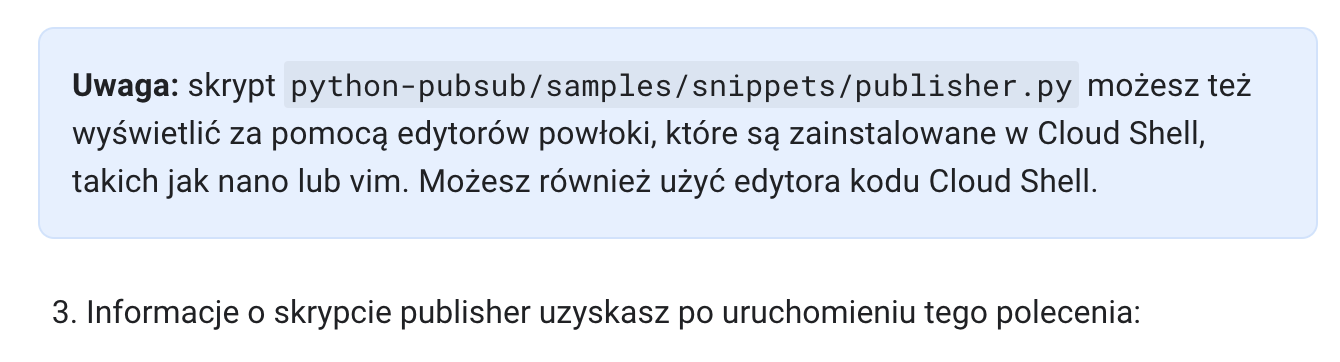

In [ ]:
python publisher.py -h

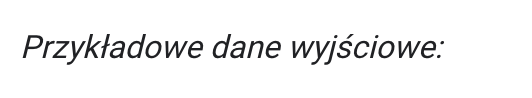

In [ ]:
usage: publisher.py [-h]
                    project
                    {list,create,delete,publish,publish-with-custom-attributes,publish-with-futures,publish-with-error-handler,publish-with-batch-settings}
                    ...
This application demonstrates how to perform basic operations on topics
with the Cloud Pub/Sub API.
For more information, see the README.md under /pubsub and the documentation
at https://cloud.google.com/pubsub/docs.
positional arguments:
  project               Your Google Cloud project ID
  {list,create,delete,publish,publish-with-custom-attributes,publish-with-futures,publish-with-error-handler,publish-with-batch-settings}
    list                Lists all Pub/Sub topics in the given project.
    create              Tworzy nowy temat Pub/Sub.
    delete              Usuwa istniejący temat Pub/Sub.
    publish             Publikuje wiele wiadomości w temacie Pub/Sub.
    publish-with-custom-attributes
                        Publikuje wiele wiadomości z niestandardowymi atrybutami
                        w temacie Pub/Sub.
    publish-with-futures
                        Publishes multiple messages to a Pub/Sub topic and
                        prints their message IDs.
    publish-with-error-handler
                        Publikuje wiele wiadomości w temacie Pub/Sub
                        z modułem obsługi błędów.
    publish-with-batch-settings
                        Publishes multiple messages to a Pub/Sub topic with
                        batch settings.
optional arguments:
  -h, --help            show this help message and exit

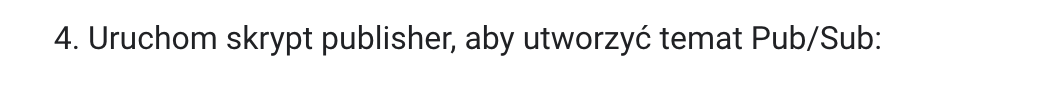

###Deploy publisher.py

In [ ]:
python publisher.py $GOOGLE_CLOUD_PROJECT create MyTopic

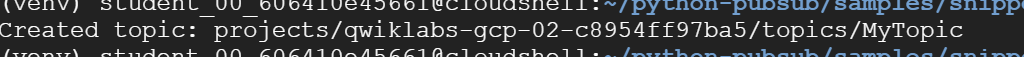

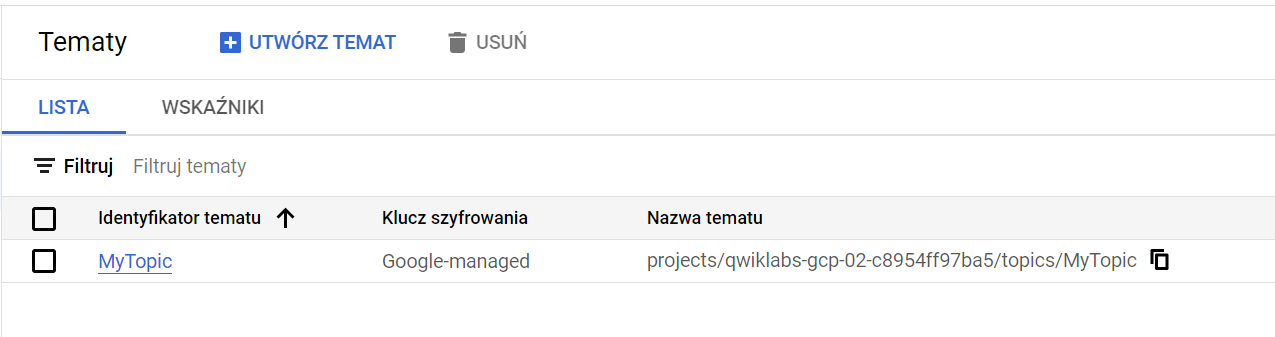

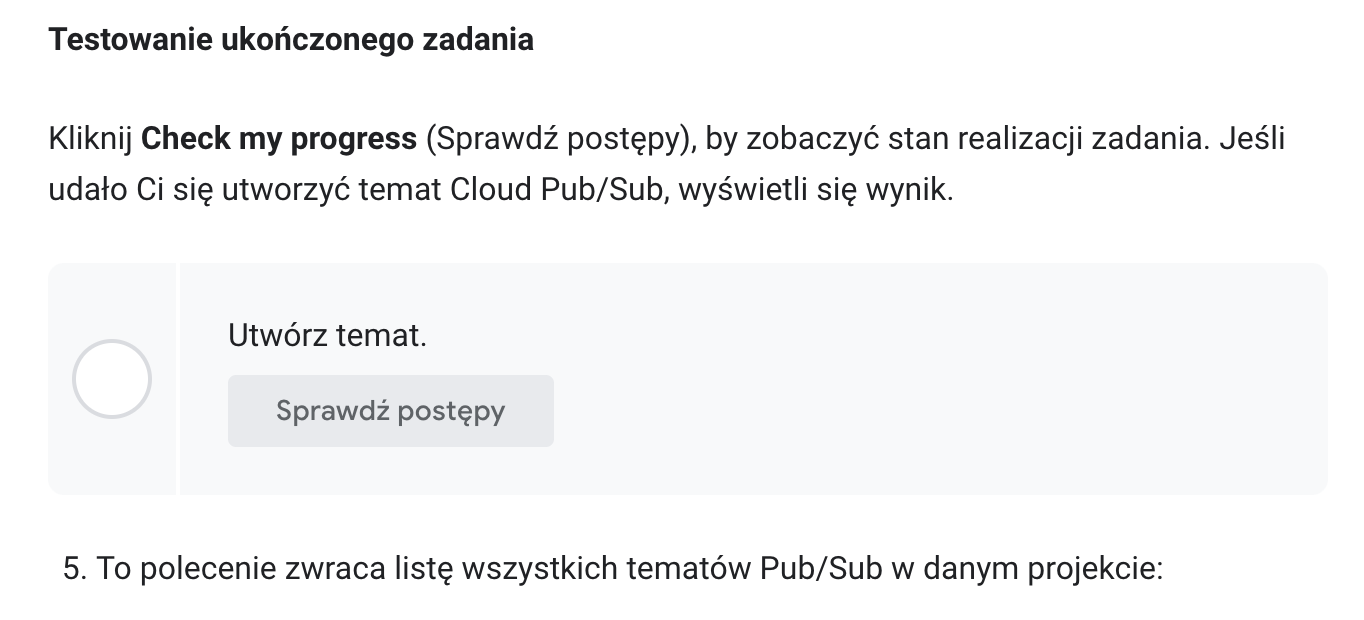

In [ ]:
python publisher.py $GOOGLE_CLOUD_PROJECT list

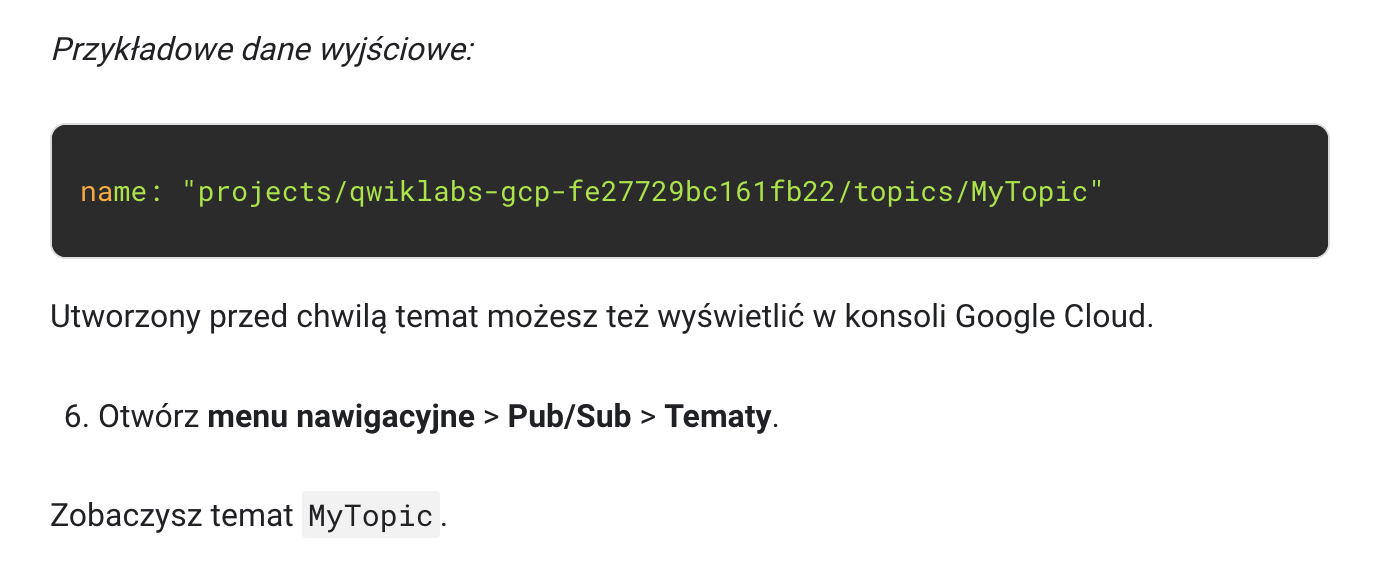

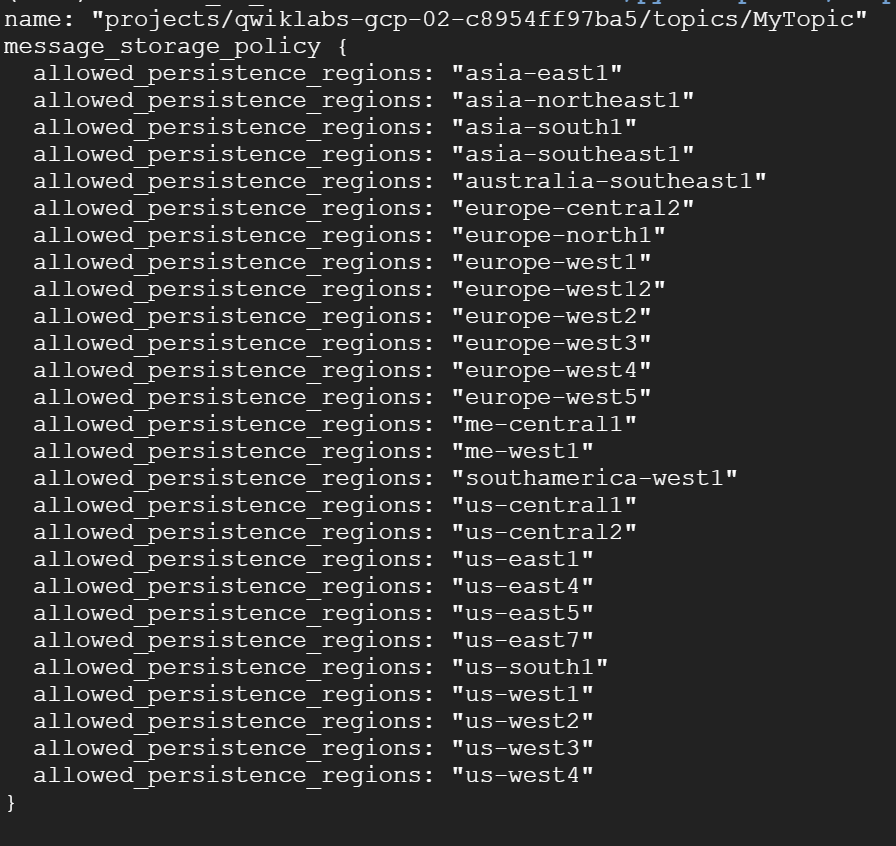

##Zadanie 5. Tworzenie subskrypcji

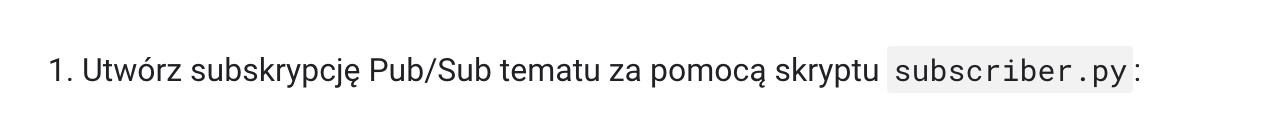

In [ ]:
python subscriber.py $GOOGLE_CLOUD_PROJECT create MyTopic MySub

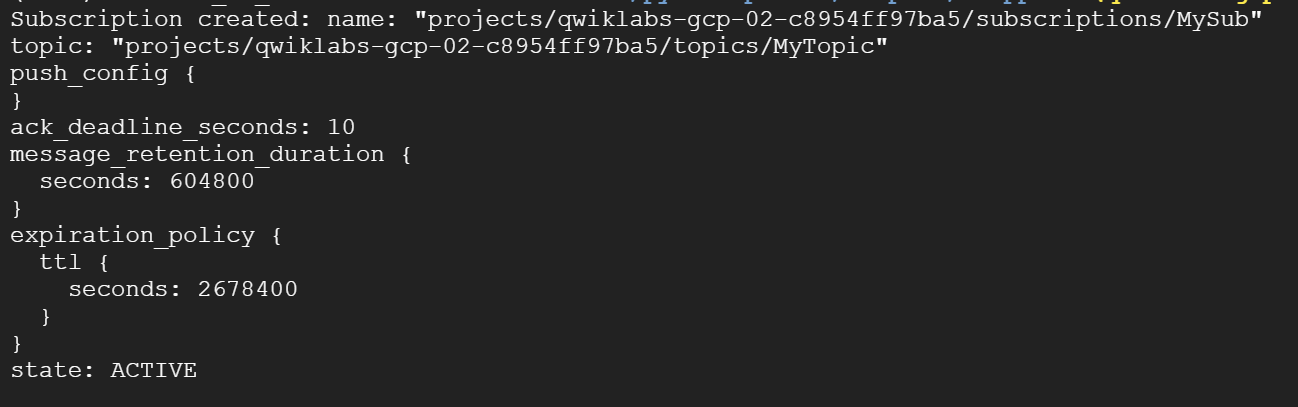

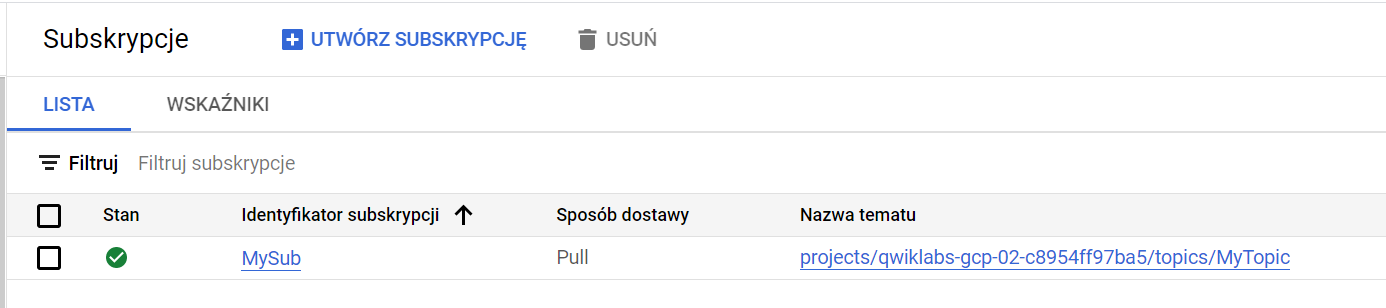

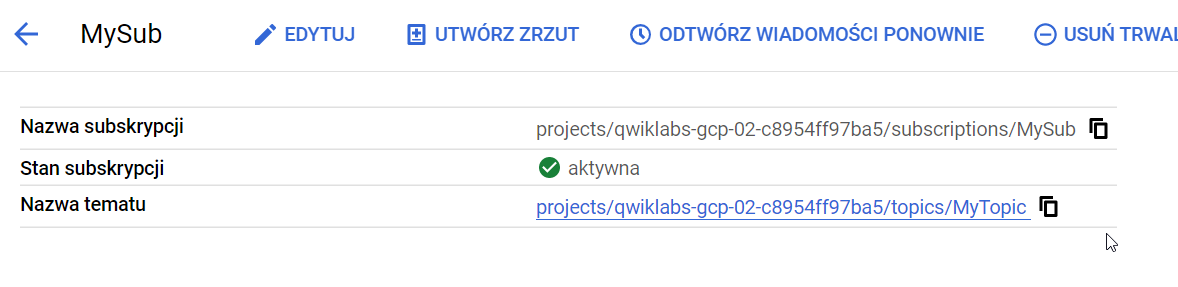

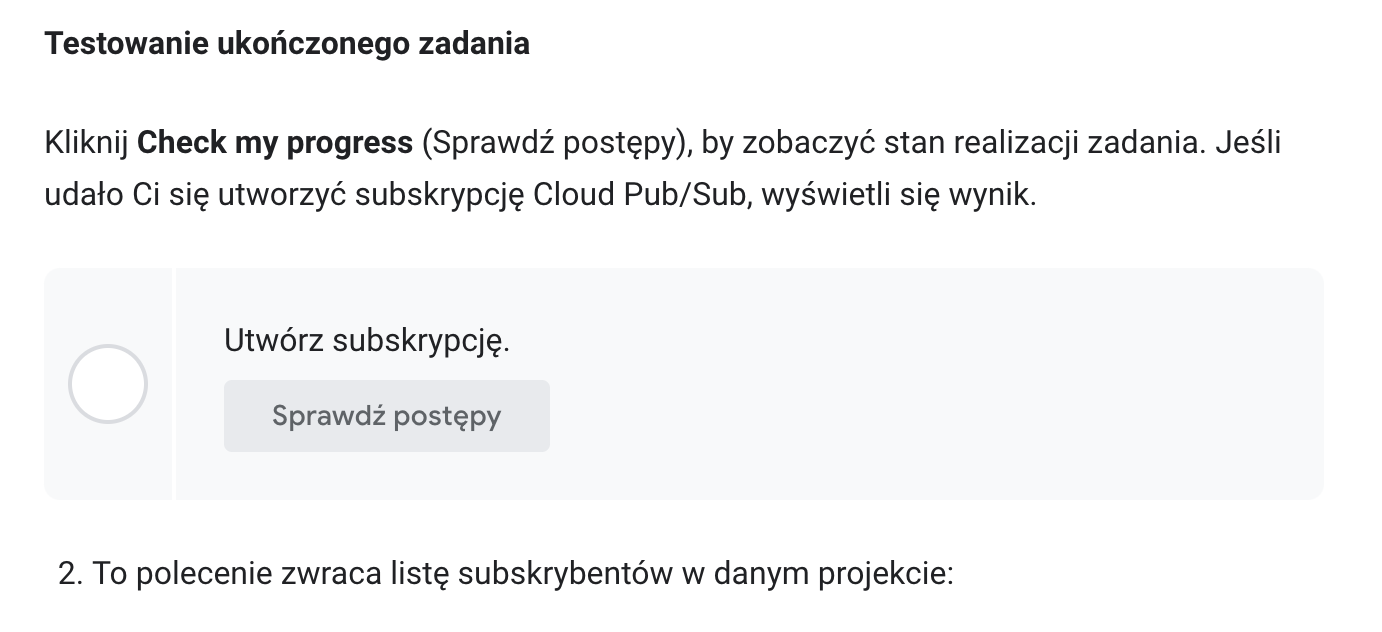

In [ ]:
python subscriber.py $GOOGLE_CLOUD_PROJECT list-in-project

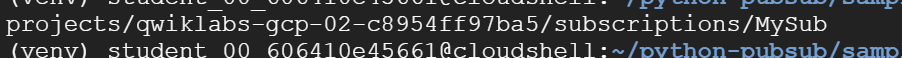

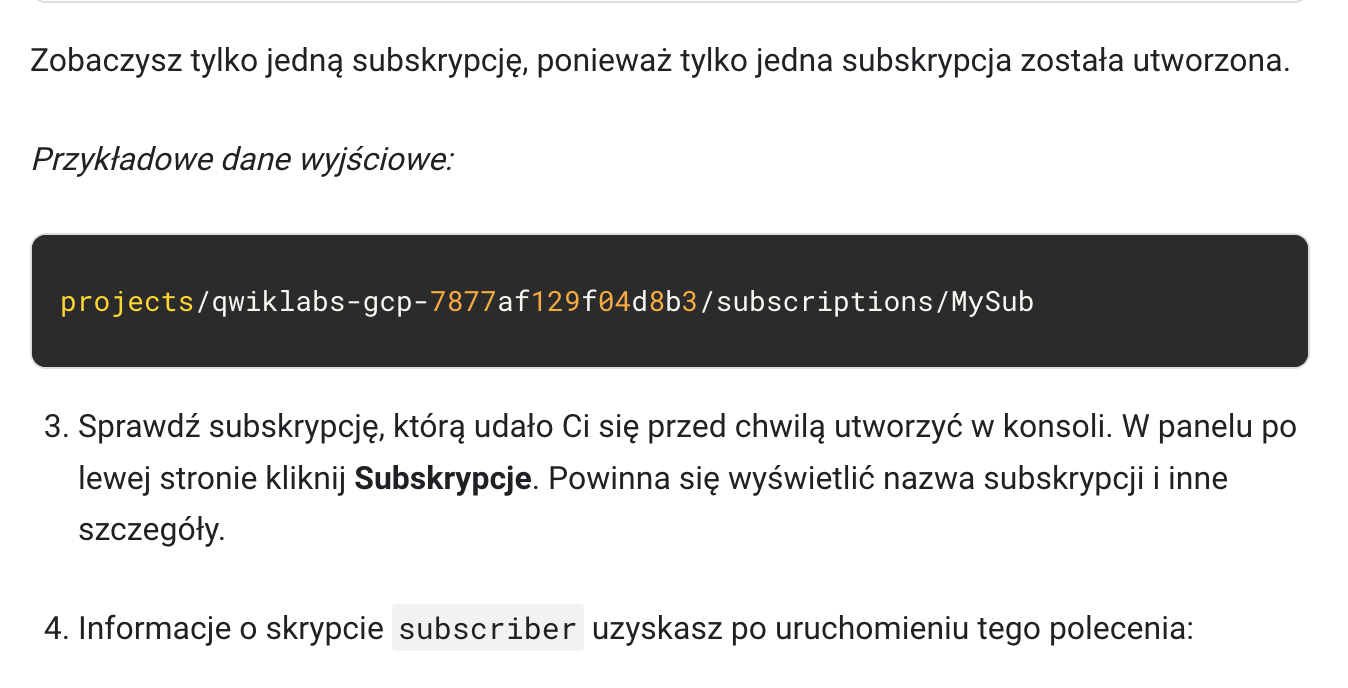

In [ ]:
python subscriber.py -h

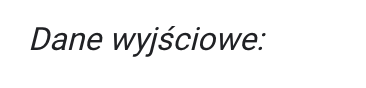

In [ ]:
usage: subscriber.py [-h]
                     project
                     {list_in_topic,list_in_project,create,create-push,delete,update,receive,receive-custom-attributes,receive-flow-control,receive-synchronously,listen_for_errors}
                     ...
This application demonstrates how to perform basic operations on
subscriptions with the Cloud Pub/Sub API.
For more information, see the README.md under /pubsub and the documentation
at https://cloud.google.com/pubsub/docs.
positional arguments:
  project               Your Google Cloud project ID
  {list_in_topic,list_in_project,create,create-push,delete,update,receive,receive-custom-attributes,receive-flow-control,receive-synchronously,listen_for_errors}
    list_in_topic       Lists all subscriptions for a given topic.
    list_in_project     Wyświetla wszystkie subskrypcje w obecnym projekcie.
    create              Tworzy nową subskrypcję „pull” w danym temacie.
    create-push         Create a new push subscription on the given topic.
    delete              Usuwa istniejący temat Pub/Sub.
    update              Aktualizuje istniejący adres URL punktu końcowego „push” subskrypcji Pub/Sub. Niektórych właściwości subskrypcji (na przykład tematu) nie można modyfikować.
    receive             Odbiera wiadomości z subskrypcji „pull”.
    receive-custom-attributes
                        Odbiera wiadomości z subskrypcji „pull”.
    receive-flow-control
                        Odbiera wiadomości z subskrypcji „pull” z kontrolą przepływu.
    receive-synchronously
                        Synchronicznie pobiera wiadomości.
    listen_for_errors   Receives messages and catches errors from a pull
                        subscription.
optional arguments:
  -h, --help            show this help message and exit

###subscriber.py (komentarze)

In [ ]:
#!/usr/bin/env python

# Copyright 2016 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""This application demonstrates how to perform basic operations on
subscriptions with the Cloud Pub/Sub API.
For more information, see the README.md under /pubsub and the documentation
at https://cloud.google.com/pubsub/docs.
"""

import argparse
import typing
from typing import Optional

if typing.TYPE_CHECKING:
    from google.pubsub_v1 import types as gapic_types


def list_subscriptions_in_topic(project_id: str, topic_id: str) -> None:
    """Lists all subscriptions for a given topic."""
    # [START pubsub_list_topic_subscriptions]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    response = publisher.list_topic_subscriptions(request={"topic": topic_path})
    for subscription in response:
        print(subscription)
    # [END pubsub_list_topic_subscriptions]


def list_subscriptions_in_project(project_id: str) -> None:
    """Lists all subscriptions in the current project."""
    # [START pubsub_list_subscriptions]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"

    subscriber = pubsub_v1.SubscriberClient()
    project_path = f"projects/{project_id}"

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        for subscription in subscriber.list_subscriptions(
            request={"project": project_path}
        ):
            print(subscription.name)
    # [END pubsub_list_subscriptions]


def create_subscription(project_id: str, topic_id: str, subscription_id: str) -> None:
    """Create a new pull subscription on the given topic."""
    # [START pubsub_create_pull_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscription = subscriber.create_subscription(
            request={"name": subscription_path, "topic": topic_path}
        )

    print(f"Subscription created: {subscription}")
    # [END pubsub_create_pull_subscription]


def create_subscription_with_dead_letter_topic(
    project_id: str,
    topic_id: str,
    subscription_id: str,
    dead_letter_topic_id: str,
    max_delivery_attempts: int = 5,
) -> None:
    """Create a subscription with dead letter policy."""
    # [START pubsub_dead_letter_create_subscription]
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import DeadLetterPolicy

    # TODO(developer)
    # project_id = "your-project-id"
    # endpoint = "https://my-test-project.appspot.com/push"
    # TODO(developer): This is an existing topic that the subscription
    # with dead letter policy is attached to.
    # topic_id = "your-topic-id"
    # TODO(developer): This is an existing subscription with a dead letter policy.
    # subscription_id = "your-subscription-id"
    # TODO(developer): This is an existing dead letter topic that the subscription
    # with dead letter policy will forward dead letter messages to.
    # dead_letter_topic_id = "your-dead-letter-topic-id"
    # TODO(developer): This is the maximum number of delivery attempts allowed
    # for a message before it gets delivered to a dead letter topic.
    # max_delivery_attempts = 5

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()

    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)
    dead_letter_topic_path = publisher.topic_path(project_id, dead_letter_topic_id)

    dead_letter_policy = DeadLetterPolicy(
        dead_letter_topic=dead_letter_topic_path,
        max_delivery_attempts=max_delivery_attempts,
    )

    with subscriber:
        request = {
            "name": subscription_path,
            "topic": topic_path,
            "dead_letter_policy": dead_letter_policy,
        }
        subscription = subscriber.create_subscription(request)

    print(f"Subscription created: {subscription.name}")
    print(
        f"It will forward dead letter messages to: {subscription.dead_letter_policy.dead_letter_topic}."
    )
    print(
        f"After {subscription.dead_letter_policy.max_delivery_attempts} delivery attempts."
    )
    # [END pubsub_dead_letter_create_subscription]


def create_push_subscription(
    project_id: str, topic_id: str, subscription_id: str, endpoint: str
) -> None:
    """Create a new push subscription on the given topic."""
    # [START pubsub_create_push_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # endpoint = "https://my-test-project.appspot.com/push"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    push_config = pubsub_v1.types.PushConfig(push_endpoint=endpoint)

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "push_config": push_config,
            }
        )

    print(f"Push subscription created: {subscription}.")
    print(f"Endpoint for subscription is: {endpoint}")
    # [END pubsub_create_push_subscription]


def create_subscription_with_ordering(
    project_id: str, topic_id: str, subscription_id: str
) -> None:
    """Create a subscription with ordering enabled."""
    # [START pubsub_enable_subscription_ordering]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "enable_message_ordering": True,
            }
        )
        print(f"Created subscription with ordering: {subscription}")
    # [END pubsub_enable_subscription_ordering]


def create_subscription_with_filtering(
    project_id: str,
    topic_id: str,
    subscription_id: str,
    filter: str,
) -> None:
    """Create a subscription with filtering enabled."""
    # [START pubsub_create_subscription_with_filter]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # filter = "attributes.author=\"unknown\""

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    with subscriber:
        subscription = subscriber.create_subscription(
            request={"name": subscription_path, "topic": topic_path, "filter": filter}
        )
        print(f"Created subscription with filtering enabled: {subscription}")
    # [END pubsub_create_subscription_with_filter]


def create_subscription_with_exactly_once_delivery(
    project_id: str, topic_id: str, subscription_id: str
) -> None:
    """Create a subscription with exactly once delivery enabled."""
    # [START pubsub_create_subscription_with_exactly_once_delivery]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "enable_exactly_once_delivery": True,
            }
        )
        print(
            f"Created subscription with exactly once delivery enabled: {subscription}"
        )
    # [END pubsub_create_subscription_with_exactly_once_delivery]


def create_bigquery_subscription(
    project_id: str, topic_id: str, subscription_id: str, bigquery_table_id: str
) -> None:
    """Create a new BigQuery subscription on the given topic."""
    # [START pubsub_create_bigquery_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # bigquery_table_id = "your-project.your-dataset.your-table"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    bigquery_config = pubsub_v1.types.BigQueryConfig(
        table=bigquery_table_id, write_metadata=True
    )

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "bigquery_config": bigquery_config,
            }
        )

    print(f"BigQuery subscription created: {subscription}.")
    print(f"Table for subscription is: {bigquery_table_id}")
    # [END pubsub_create_bigquery_subscription]


def delete_subscription(project_id: str, subscription_id: str) -> None:
    """Deletes an existing Pub/Sub topic."""
    # [START pubsub_delete_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscriber.delete_subscription(request={"subscription": subscription_path})

    print(f"Subscription deleted: {subscription_path}.")
    # [END pubsub_delete_subscription]


def update_push_subscription(
    project_id: str, topic_id: str, subscription_id: str, endpoint: str
) -> None:
    """
    Updates an existing Pub/Sub subscription's push endpoint URL.
    Note that certain properties of a subscription, such as
    its topic, are not modifiable.
    """
    # [START pubsub_update_push_configuration]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # endpoint = "https://my-test-project.appspot.com/push"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    push_config = pubsub_v1.types.PushConfig(push_endpoint=endpoint)

    subscription = pubsub_v1.types.Subscription(
        name=subscription_path, topic=topic_id, push_config=push_config
    )

    update_mask = {"paths": {"push_config"}}

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        result = subscriber.update_subscription(
            request={"subscription": subscription, "update_mask": update_mask}
        )

    print(f"Subscription updated: {subscription_path}")
    print(f"New endpoint for subscription is: {result.push_config}.")
    # [END pubsub_update_push_configuration]


def update_subscription_with_dead_letter_policy(
    project_id: str,
    topic_id: str,
    subscription_id: str,
    dead_letter_topic_id: str,
    max_delivery_attempts: int = 5,
) -> "gapic_types.Subscription":
    """Update a subscription's dead letter policy."""
    # [START pubsub_dead_letter_update_subscription]
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import DeadLetterPolicy, FieldMask

    # TODO(developer)
    # project_id = "your-project-id"
    # TODO(developer): This is an existing topic that the subscription
    # with dead letter policy is attached to.
    # topic_id = "your-topic-id"
    # TODO(developer): This is an existing subscription with a dead letter policy.
    # subscription_id = "your-subscription-id"
    # TODO(developer): This is an existing dead letter topic that the subscription
    # with dead letter policy will forward dead letter messages to.
    # dead_letter_topic_id = "your-dead-letter-topic-id"
    # TODO(developer): This is the maximum number of delivery attempts allowed
    # for a message before it gets delivered to a dead letter topic.
    # max_delivery_attempts = 5

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()

    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)
    dead_letter_topic_path = publisher.topic_path(project_id, dead_letter_topic_id)

    subscription_before_update = subscriber.get_subscription(
        request={"subscription": subscription_path}
    )
    print(f"Before the update: {subscription_before_update}.")

    # Indicates which fields in the provided subscription to update.
    update_mask = FieldMask(paths=["dead_letter_policy"])

    # Construct a dead letter policy you expect to have after the update.
    dead_letter_policy = DeadLetterPolicy(
        dead_letter_topic=dead_letter_topic_path,
        max_delivery_attempts=max_delivery_attempts,
    )

    # Construct the subscription with the dead letter policy you expect to have
    # after the update. Here, values in the required fields (name, topic) help
    # identify the subscription.
    subscription = pubsub_v1.types.Subscription(
        name=subscription_path,
        topic=topic_path,
        dead_letter_policy=dead_letter_policy,
    )

    with subscriber:
        subscription_after_update = subscriber.update_subscription(
            request={"subscription": subscription, "update_mask": update_mask}
        )

    print(f"After the update: {subscription_after_update}.")
    # [END pubsub_dead_letter_update_subscription]
    return subscription_after_update


def remove_dead_letter_policy(
    project_id: str, topic_id: str, subscription_id: str
) -> "gapic_types.Subscription":
    """Remove dead letter policy from a subscription."""
    # [START pubsub_dead_letter_remove]
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import FieldMask

    # TODO(developer)
    # project_id = "your-project-id"
    # TODO(developer): This is an existing topic that the subscription
    # with dead letter policy is attached to.
    # topic_id = "your-topic-id"
    # TODO(developer): This is an existing subscription with a dead letter policy.
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    subscription_before_update = subscriber.get_subscription(
        request={"subscription": subscription_path}
    )
    print(f"Before removing the policy: {subscription_before_update}.")

    # Indicates which fields in the provided subscription to update.
    update_mask = FieldMask(paths=["dead_letter_policy"])

    # Construct the subscription (without any dead letter policy) that you
    # expect to have after the update.
    subscription = pubsub_v1.types.Subscription(
        name=subscription_path, topic=topic_path
    )

    with subscriber:
        subscription_after_update = subscriber.update_subscription(
            request={"subscription": subscription, "update_mask": update_mask}
        )

    print(f"After removing the policy: {subscription_after_update}.")
    # [END pubsub_dead_letter_remove]
    return subscription_after_update


def receive_messages(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription."""
    # [START pubsub_subscriber_async_pull]
    # [START pubsub_quickstart_subscriber]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    # The `subscription_path` method creates a fully qualified identifier
    # in the form `projects/{project_id}/subscriptions/{subscription_id}`
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_async_pull]
    # [END pubsub_quickstart_subscriber]


def receive_messages_with_custom_attributes(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription."""
    # [START pubsub_subscriber_async_pull_custom_attributes]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message.data!r}.")
        if message.attributes:
            print("Attributes:")
            for key in message.attributes:
                value = message.attributes.get(key)
                print(f"{key}: {value}")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_async_pull_custom_attributes]


def receive_messages_with_flow_control(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription with flow control."""
    # [START pubsub_subscriber_flow_settings]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message.data!r}.")
        message.ack()

    # Limit the subscriber to only have ten outstanding messages at a time.
    flow_control = pubsub_v1.types.FlowControl(max_messages=10)

    streaming_pull_future = subscriber.subscribe(
        subscription_path, callback=callback, flow_control=flow_control
    )
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_flow_settings]


def receive_messages_with_blocking_shutdown(
    project_id: str, subscription_id: str, timeout: float = 5.0
) -> None:
    """Shuts down a pull subscription by awaiting message callbacks to complete."""
    # [START pubsub_subscriber_blocking_shutdown]
    import time
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message.data!r}.")
        time.sleep(timeout + 3.0)  # Pocess longer than streaming pull future timeout.
        message.ack()
        print(f"Done processing the message {message.data!r}.")

    streaming_pull_future = subscriber.subscribe(
        subscription_path,
        callback=callback,
        await_callbacks_on_shutdown=True,
    )
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()
            print("Streaming pull future canceled.")
            streaming_pull_future.result()  # Blocks until shutdown complete.
            print("Done waiting for the stream shutdown.")

    # The "Done waiting..." message is only printed *after* the processing of all
    # received messages has completed.
    # [END pubsub_subscriber_blocking_shutdown]


def receive_messages_with_exactly_once_delivery_enabled(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription with exactly-once delivery enabled.
    This is a preview feature. For more details, see:
    https://cloud.google.com/pubsub/docs/exactly-once-delivery."
    """
    # [START pubsub_subscriber_exactly_once]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.subscriber import exceptions as sub_exceptions

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    # The `subscription_path` method creates a fully qualified identifier
    # in the form `projects/{project_id}/subscriptions/{subscription_id}`
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")

        # Use `ack_with_response()` instead of `ack()` to get a future that tracks
        # the result of the acknowledge call. When exactly-once delivery is enabled
        # on the subscription, the message is guaranteed to not be delivered again
        # if the ack future succeeds.
        ack_future = message.ack_with_response()

        try:
            # Block on result of acknowledge call.
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            ack_future.result(timeout=timeout)
            print(f"Ack for message {message.message_id} successful.")
        except sub_exceptions.AcknowledgeError as e:
            print(
                f"Ack for message {message.message_id} failed with error: {e.error_code}"
            )

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_exactly_once]


def synchronous_pull(project_id: str, subscription_id: str) -> None:
    """Pulling messages synchronously."""
    # [START pubsub_subscriber_sync_pull]
    from google.api_core import retry
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    NUM_MESSAGES = 3

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        # The subscriber pulls a specific number of messages. The actual
        # number of messages pulled may be smaller than max_messages.
        response = subscriber.pull(
            request={"subscription": subscription_path, "max_messages": NUM_MESSAGES},
            retry=retry.Retry(deadline=300),
        )

        if len(response.received_messages) == 0:
            return

        ack_ids = []
        for received_message in response.received_messages:
            print(f"Received: {received_message.message.data}.")
            ack_ids.append(received_message.ack_id)

        # Acknowledges the received messages so they will not be sent again.
        subscriber.acknowledge(
            request={"subscription": subscription_path, "ack_ids": ack_ids}
        )

        print(
            f"Received and acknowledged {len(response.received_messages)} messages from {subscription_path}."
        )
    # [END pubsub_subscriber_sync_pull]


def synchronous_pull_with_lease_management(
    project_id: str, subscription_id: str
) -> None:
    """Pulling messages synchronously with lease management"""
    # [START pubsub_subscriber_sync_pull_with_lease]
    import logging
    import multiprocessing
    import sys
    import time

    from google.api_core import retry
    from google.cloud import pubsub_v1

    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    processes = dict()

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    response = subscriber.pull(
        request={"subscription": subscription_path, "max_messages": 3},
        retry=retry.Retry(deadline=300),
    )

    if len(response.received_messages) == 0:
        return

    # Start a process for each message based on its size modulo 10.
    for message in response.received_messages:
        process = multiprocessing.Process(
            target=time.sleep, args=(sys.getsizeof(message) % 10,)
        )
        processes[process] = (message.ack_id, message.message.data)
        process.start()

    while processes:
        # Take a break every second.
        if processes:
            time.sleep(1)

        for process in list(processes):
            ack_id, msg_data = processes[process]
            # If the process is running, reset the ack deadline.
            if process.is_alive():
                subscriber.modify_ack_deadline(
                    request={
                        "subscription": subscription_path,
                        "ack_ids": [ack_id],
                        # Must be between 10 and 600.
                        "ack_deadline_seconds": 15,
                    }
                )
                logger.debug(f"Reset ack deadline for {msg_data}.")

            # If the process is complete, acknowledge the message.
            else:
                subscriber.acknowledge(
                    request={"subscription": subscription_path, "ack_ids": [ack_id]}
                )
                logger.debug(f"Acknowledged {msg_data}.")
                processes.pop(process)
    print(
        f"Received and acknowledged {len(response.received_messages)} messages from {subscription_path}."
    )

    # Close the underlying gPRC channel. Alternatively, wrap subscriber in
    # a 'with' block to automatically call close() when done.
    subscriber.close()
    # [END pubsub_subscriber_sync_pull_with_lease]


def listen_for_errors(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages and catches errors from a pull subscription."""
    # [START pubsub_subscriber_error_listener]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        # When `timeout` is not set, result() will block indefinitely,
        # unless an exception is encountered first.
        try:
            streaming_pull_future.result(timeout=timeout)
        except Exception as e:
            print(
                f"Listening for messages on {subscription_path} threw an exception: {e}."
            )
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_error_listener]


def receive_messages_with_delivery_attempts(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    # [START pubsub_dead_letter_delivery_attempt]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")
        print(f"With delivery attempts: {message.delivery_attempt}.")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        # When `timeout` is not set, result() will block indefinitely,
        # unless an exception is encountered first.
        try:
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_dead_letter_delivery_attempt]


"""Obsługa Argumentów Linii Poleceń:
Używa modułu argparse do tworzenia parsera argumentów, który umożliwia użytkownikowi wprowadzanie
różnych poleceń i parametrów w linii poleceń."""

if __name__ == "__main__":  # noqa
    parser = argparse.ArgumentParser(
        description=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter,
    )
    parser.add_argument("project_id", help="Your Google Cloud project ID")

    subparsers = parser.add_subparsers(dest="command")
    list_in_topic_parser = subparsers.add_parser(
        "list-in-topic", help=list_subscriptions_in_topic.__doc__
    )
    list_in_topic_parser.add_argument("topic_id")

    list_in_project_parser = subparsers.add_parser(
        "list-in-project", help=list_subscriptions_in_project.__doc__
    )

    create_parser = subparsers.add_parser("create", help=create_subscription.__doc__)
    create_parser.add_argument("topic_id")
    create_parser.add_argument("subscription_id")

    create_with_dead_letter_policy_parser = subparsers.add_parser(
        "create-with-dead-letter-policy",
        help=create_subscription_with_dead_letter_topic.__doc__,
    )
    create_with_dead_letter_policy_parser.add_argument("topic_id")
    create_with_dead_letter_policy_parser.add_argument("subscription_id")
    create_with_dead_letter_policy_parser.add_argument("dead_letter_topic_id")
    create_with_dead_letter_policy_parser.add_argument(
        "max_delivery_attempts", type=int, nargs="?", default=5
    )

    create_push_parser = subparsers.add_parser(
        "create-push", help=create_push_subscription.__doc__
    )
    create_push_parser.add_argument("topic_id")
    create_push_parser.add_argument("subscription_id")
    create_push_parser.add_argument("endpoint")

    create_subscription_with_ordering_parser = subparsers.add_parser(
        "create-with-ordering", help=create_subscription_with_ordering.__doc__
    )
    create_subscription_with_ordering_parser.add_argument("topic_id")
    create_subscription_with_ordering_parser.add_argument("subscription_id")

    create_subscription_with_filtering_parser = subparsers.add_parser(
        "create-with-filtering", help=create_subscription_with_filtering.__doc__
    )
    create_subscription_with_filtering_parser.add_argument("topic_id")
    create_subscription_with_filtering_parser.add_argument("subscription_id")
    create_subscription_with_filtering_parser.add_argument("filter")

    create_subscription_with_exactly_once_delivery_parser = subparsers.add_parser(
        "create-with-exactly-once",
        help=create_subscription_with_exactly_once_delivery.__doc__,
    )
    create_subscription_with_exactly_once_delivery_parser.add_argument("topic_id")
    create_subscription_with_exactly_once_delivery_parser.add_argument(
        "subscription_id"
    )

    create_bigquery_subscription_parser = subparsers.add_parser(
        "create-biquery",
        help=create_bigquery_subscription.__doc__,
    )
    create_bigquery_subscription_parser.add_argument("topic_id")
    create_bigquery_subscription_parser.add_argument("subscription_id")
    create_bigquery_subscription_parser.add_argument("bigquery_table_id")

    delete_parser = subparsers.add_parser("delete", help=delete_subscription.__doc__)
    delete_parser.add_argument("subscription_id")

    update_push_parser = subparsers.add_parser(
        "update-push", help=update_push_subscription.__doc__
    )
    update_push_parser.add_argument("topic_id")
    update_push_parser.add_argument("subscription_id")
    update_push_parser.add_argument("endpoint")

    update_dead_letter_policy_parser = subparsers.add_parser(
        "update-dead-letter-policy",
        help=update_subscription_with_dead_letter_policy.__doc__,
    )
    update_dead_letter_policy_parser.add_argument("topic_id")
    update_dead_letter_policy_parser.add_argument("subscription_id")
    update_dead_letter_policy_parser.add_argument("dead_letter_topic_id")
    update_dead_letter_policy_parser.add_argument(
        "max_delivery_attempts", type=int, nargs="?", default=5
    )

    remove_dead_letter_policy_parser = subparsers.add_parser(
        "remove-dead-letter-policy", help=remove_dead_letter_policy.__doc__
    )
    remove_dead_letter_policy_parser.add_argument("topic_id")
    remove_dead_letter_policy_parser.add_argument("subscription_id")

    receive_parser = subparsers.add_parser("receive", help=receive_messages.__doc__)
    receive_parser.add_argument("subscription_id")
    receive_parser.add_argument("timeout", default=None, type=float, nargs="?")

    receive_with_custom_attributes_parser = subparsers.add_parser(
        "receive-custom-attributes",
        help=receive_messages_with_custom_attributes.__doc__,
    )
    receive_with_custom_attributes_parser.add_argument("subscription_id")
    receive_with_custom_attributes_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_with_flow_control_parser = subparsers.add_parser(
        "receive-flow-control", help=receive_messages_with_flow_control.__doc__
    )
    receive_with_flow_control_parser.add_argument("subscription_id")
    receive_with_flow_control_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_with_blocking_shutdown_parser = subparsers.add_parser(
        "receive-blocking-shutdown",
        help=receive_messages_with_blocking_shutdown.__doc__,
    )
    receive_with_blocking_shutdown_parser.add_argument("subscription_id")
    receive_with_blocking_shutdown_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_messages_with_exactly_once_delivery_enabled_parser = subparsers.add_parser(
        "receive-messages-with-exactly-once-delivery-enabled",
        help=receive_messages_with_exactly_once_delivery_enabled.__doc__,
    )
    receive_messages_with_exactly_once_delivery_enabled_parser.add_argument(
        "subscription_id"
    )
    receive_messages_with_exactly_once_delivery_enabled_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    synchronous_pull_parser = subparsers.add_parser(
        "receive-synchronously", help=synchronous_pull.__doc__
    )
    synchronous_pull_parser.add_argument("subscription_id")

    synchronous_pull_with_lease_management_parser = subparsers.add_parser(
        "receive-synchronously-with-lease",
        help=synchronous_pull_with_lease_management.__doc__,
    )
    synchronous_pull_with_lease_management_parser.add_argument("subscription_id")

    listen_for_errors_parser = subparsers.add_parser(
        "listen-for-errors", help=listen_for_errors.__doc__
    )
    listen_for_errors_parser.add_argument("subscription_id")
    listen_for_errors_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_messages_with_delivery_attempts_parser = subparsers.add_parser(
        "receive-messages-with-delivery-attempts",
        help=receive_messages_with_delivery_attempts.__doc__,
    )
    receive_messages_with_delivery_attempts_parser.add_argument("subscription_id")
    receive_messages_with_delivery_attempts_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    args = parser.parse_args()

    if args.command == "list-in-topic":
        list_subscriptions_in_topic(args.project_id, args.topic_id)
    elif args.command == "list-in-project":
        list_subscriptions_in_project(args.project_id)
    elif args.command == "create":
        create_subscription(args.project_id, args.topic_id, args.subscription_id)
    elif args.command == "create-with-dead-letter-policy":
        create_subscription_with_dead_letter_topic(
            args.project_id,
            args.topic_id,
            args.subscription_id,
            args.dead_letter_topic_id,
            args.max_delivery_attempts,
        )
    elif args.command == "create-push":
        create_push_subscription(
            args.project_id, args.topic_id, args.subscription_id, args.endpoint
        )
    elif args.command == "create-with-ordering":
        create_subscription_with_ordering(
            args.project_id, args.topic_id, args.subscription_id
        )
    elif args.command == "create-with-filtering":
        create_subscription_with_filtering(
            args.project_id, args.topic_id, args.subscription_id, args.filter
        )
    elif args.command == "create-with-exactly-once":
        create_subscription_with_exactly_once_delivery(
            args.project_id, args.topic_id, args.subscription_id
        )
    elif args.command == "create-bigquery":
        create_bigquery_subscription(
            args.project_id,
            args.topic_id,
            args.subscription_id,
            args.bigquery_table_id,
        )
    elif args.command == "delete":
        delete_subscription(args.project_id, args.subscription_id)
    elif args.command == "update-push":
        update_push_subscription(
            args.project_id, args.topic_id, args.subscription_id, args.endpoint
        )
    elif args.command == "update-dead-letter-policy":
        update_subscription_with_dead_letter_policy(
            args.project_id,
            args.topic_id,
            args.subscription_id,
            args.dead_letter_topic_id,
            args.max_delivery_attempts,
        )
    elif args.command == "remove-dead-letter-policy":
        remove_dead_letter_policy(args.project_id, args.topic_id, args.subscription_id)
    elif args.command == "receive":
        receive_messages(args.project_id, args.subscription_id, args.timeout)
    elif args.command == "receive-custom-attributes":
        receive_messages_with_custom_attributes(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-flow-control":
        receive_messages_with_flow_control(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-blocking-shutdown":
        receive_messages_with_blocking_shutdown(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-messages-with-exactly-once-delivery-enabled":
        receive_messages_with_exactly_once_delivery_enabled(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-synchronously":
        synchronous_pull(args.project_id, args.subscription_id)
    elif args.command == "receive-synchronously-with-lease":
        synchronous_pull_with_lease_management(args.project_id, args.subscription_id)
    elif args.command == "listen-for-errors":
        listen_for_errors(args.project_id, args.subscription_id, args.timeout)
    elif args.command == "receive-messages-with-delivery-attempts":
        receive_messages_with_delivery_attempts(
            args.project_id, args.subscription_id, args.timeout
        )
Footer

###subscriber.py

In [ ]:
#!/usr/bin/env python

# Copyright 2016 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""This application demonstrates how to perform basic operations on
subscriptions with the Cloud Pub/Sub API.
For more information, see the README.md under /pubsub and the documentation
at https://cloud.google.com/pubsub/docs.
"""

import argparse
import typing
from typing import Optional

if typing.TYPE_CHECKING:
    from google.pubsub_v1 import types as gapic_types


def list_subscriptions_in_topic(project_id: str, topic_id: str) -> None:
    """Lists all subscriptions for a given topic."""
    # [START pubsub_list_topic_subscriptions]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"

    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path(project_id, topic_id)

    response = publisher.list_topic_subscriptions(request={"topic": topic_path})
    for subscription in response:
        print(subscription)
    # [END pubsub_list_topic_subscriptions]


def list_subscriptions_in_project(project_id: str) -> None:
    """Lists all subscriptions in the current project."""
    # [START pubsub_list_subscriptions]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"

    subscriber = pubsub_v1.SubscriberClient()
    project_path = f"projects/{project_id}"

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        for subscription in subscriber.list_subscriptions(
            request={"project": project_path}
        ):
            print(subscription.name)
    # [END pubsub_list_subscriptions]


def create_subscription(project_id: str, topic_id: str, subscription_id: str) -> None:
    """Create a new pull subscription on the given topic."""
    # [START pubsub_create_pull_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscription = subscriber.create_subscription(
            request={"name": subscription_path, "topic": topic_path}
        )

    print(f"Subscription created: {subscription}")
    # [END pubsub_create_pull_subscription]


def create_subscription_with_dead_letter_topic(
    project_id: str,
    topic_id: str,
    subscription_id: str,
    dead_letter_topic_id: str,
    max_delivery_attempts: int = 5,
) -> None:
    """Create a subscription with dead letter policy."""
    # [START pubsub_dead_letter_create_subscription]
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import DeadLetterPolicy

    # TODO(developer)
    # project_id = "your-project-id"
    # endpoint = "https://my-test-project.appspot.com/push"
    # TODO(developer): This is an existing topic that the subscription
    # with dead letter policy is attached to.
    # topic_id = "your-topic-id"
    # TODO(developer): This is an existing subscription with a dead letter policy.
    # subscription_id = "your-subscription-id"
    # TODO(developer): This is an existing dead letter topic that the subscription
    # with dead letter policy will forward dead letter messages to.
    # dead_letter_topic_id = "your-dead-letter-topic-id"
    # TODO(developer): This is the maximum number of delivery attempts allowed
    # for a message before it gets delivered to a dead letter topic.
    # max_delivery_attempts = 5

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()

    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)
    dead_letter_topic_path = publisher.topic_path(project_id, dead_letter_topic_id)

    dead_letter_policy = DeadLetterPolicy(
        dead_letter_topic=dead_letter_topic_path,
        max_delivery_attempts=max_delivery_attempts,
    )

    with subscriber:
        request = {
            "name": subscription_path,
            "topic": topic_path,
            "dead_letter_policy": dead_letter_policy,
        }
        subscription = subscriber.create_subscription(request)

    print(f"Subscription created: {subscription.name}")
    print(
        f"It will forward dead letter messages to: {subscription.dead_letter_policy.dead_letter_topic}."
    )
    print(
        f"After {subscription.dead_letter_policy.max_delivery_attempts} delivery attempts."
    )
    # [END pubsub_dead_letter_create_subscription]


def create_push_subscription(
    project_id: str, topic_id: str, subscription_id: str, endpoint: str
) -> None:
    """Create a new push subscription on the given topic."""
    # [START pubsub_create_push_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # endpoint = "https://my-test-project.appspot.com/push"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    push_config = pubsub_v1.types.PushConfig(push_endpoint=endpoint)

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "push_config": push_config,
            }
        )

    print(f"Push subscription created: {subscription}.")
    print(f"Endpoint for subscription is: {endpoint}")
    # [END pubsub_create_push_subscription]


def create_subscription_with_ordering(
    project_id: str, topic_id: str, subscription_id: str
) -> None:
    """Create a subscription with ordering enabled."""
    # [START pubsub_enable_subscription_ordering]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "enable_message_ordering": True,
            }
        )
        print(f"Created subscription with ordering: {subscription}")
    # [END pubsub_enable_subscription_ordering]


def create_subscription_with_filtering(
    project_id: str,
    topic_id: str,
    subscription_id: str,
    filter: str,
) -> None:
    """Create a subscription with filtering enabled."""
    # [START pubsub_create_subscription_with_filter]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # filter = "attributes.author=\"unknown\""

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    with subscriber:
        subscription = subscriber.create_subscription(
            request={"name": subscription_path, "topic": topic_path, "filter": filter}
        )
        print(f"Created subscription with filtering enabled: {subscription}")
    # [END pubsub_create_subscription_with_filter]


def create_subscription_with_exactly_once_delivery(
    project_id: str, topic_id: str, subscription_id: str
) -> None:
    """Create a subscription with exactly once delivery enabled."""
    # [START pubsub_create_subscription_with_exactly_once_delivery]
    from google.cloud import pubsub_v1

    # TODO(developer): Choose an existing topic.
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "enable_exactly_once_delivery": True,
            }
        )
        print(
            f"Created subscription with exactly once delivery enabled: {subscription}"
        )
    # [END pubsub_create_subscription_with_exactly_once_delivery]


def create_bigquery_subscription(
    project_id: str, topic_id: str, subscription_id: str, bigquery_table_id: str
) -> None:
    """Create a new BigQuery subscription on the given topic."""
    # [START pubsub_create_bigquery_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # bigquery_table_id = "your-project.your-dataset.your-table"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    bigquery_config = pubsub_v1.types.BigQueryConfig(
        table=bigquery_table_id, write_metadata=True
    )

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscription = subscriber.create_subscription(
            request={
                "name": subscription_path,
                "topic": topic_path,
                "bigquery_config": bigquery_config,
            }
        )

    print(f"BigQuery subscription created: {subscription}.")
    print(f"Table for subscription is: {bigquery_table_id}")
    # [END pubsub_create_bigquery_subscription]


def delete_subscription(project_id: str, subscription_id: str) -> None:
    """Deletes an existing Pub/Sub topic."""
    # [START pubsub_delete_subscription]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        subscriber.delete_subscription(request={"subscription": subscription_path})

    print(f"Subscription deleted: {subscription_path}.")
    # [END pubsub_delete_subscription]


def update_push_subscription(
    project_id: str, topic_id: str, subscription_id: str, endpoint: str
) -> None:
    """
    Updates an existing Pub/Sub subscription's push endpoint URL.
    Note that certain properties of a subscription, such as
    its topic, are not modifiable.
    """
    # [START pubsub_update_push_configuration]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # topic_id = "your-topic-id"
    # subscription_id = "your-subscription-id"
    # endpoint = "https://my-test-project.appspot.com/push"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    push_config = pubsub_v1.types.PushConfig(push_endpoint=endpoint)

    subscription = pubsub_v1.types.Subscription(
        name=subscription_path, topic=topic_id, push_config=push_config
    )

    update_mask = {"paths": {"push_config"}}

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        result = subscriber.update_subscription(
            request={"subscription": subscription, "update_mask": update_mask}
        )

    print(f"Subscription updated: {subscription_path}")
    print(f"New endpoint for subscription is: {result.push_config}.")
    # [END pubsub_update_push_configuration]


def update_subscription_with_dead_letter_policy(
    project_id: str,
    topic_id: str,
    subscription_id: str,
    dead_letter_topic_id: str,
    max_delivery_attempts: int = 5,
) -> "gapic_types.Subscription":
    """Update a subscription's dead letter policy."""
    # [START pubsub_dead_letter_update_subscription]
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import DeadLetterPolicy, FieldMask

    # TODO(developer)
    # project_id = "your-project-id"
    # TODO(developer): This is an existing topic that the subscription
    # with dead letter policy is attached to.
    # topic_id = "your-topic-id"
    # TODO(developer): This is an existing subscription with a dead letter policy.
    # subscription_id = "your-subscription-id"
    # TODO(developer): This is an existing dead letter topic that the subscription
    # with dead letter policy will forward dead letter messages to.
    # dead_letter_topic_id = "your-dead-letter-topic-id"
    # TODO(developer): This is the maximum number of delivery attempts allowed
    # for a message before it gets delivered to a dead letter topic.
    # max_delivery_attempts = 5

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()

    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)
    dead_letter_topic_path = publisher.topic_path(project_id, dead_letter_topic_id)

    subscription_before_update = subscriber.get_subscription(
        request={"subscription": subscription_path}
    )
    print(f"Before the update: {subscription_before_update}.")

    # Indicates which fields in the provided subscription to update.
    update_mask = FieldMask(paths=["dead_letter_policy"])

    # Construct a dead letter policy you expect to have after the update.
    dead_letter_policy = DeadLetterPolicy(
        dead_letter_topic=dead_letter_topic_path,
        max_delivery_attempts=max_delivery_attempts,
    )

    # Construct the subscription with the dead letter policy you expect to have
    # after the update. Here, values in the required fields (name, topic) help
    # identify the subscription.
    subscription = pubsub_v1.types.Subscription(
        name=subscription_path,
        topic=topic_path,
        dead_letter_policy=dead_letter_policy,
    )

    with subscriber:
        subscription_after_update = subscriber.update_subscription(
            request={"subscription": subscription, "update_mask": update_mask}
        )

    print(f"After the update: {subscription_after_update}.")
    # [END pubsub_dead_letter_update_subscription]
    return subscription_after_update


def remove_dead_letter_policy(
    project_id: str, topic_id: str, subscription_id: str
) -> "gapic_types.Subscription":
    """Remove dead letter policy from a subscription."""
    # [START pubsub_dead_letter_remove]
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.types import FieldMask

    # TODO(developer)
    # project_id = "your-project-id"
    # TODO(developer): This is an existing topic that the subscription
    # with dead letter policy is attached to.
    # topic_id = "your-topic-id"
    # TODO(developer): This is an existing subscription with a dead letter policy.
    # subscription_id = "your-subscription-id"

    publisher = pubsub_v1.PublisherClient()
    subscriber = pubsub_v1.SubscriberClient()
    topic_path = publisher.topic_path(project_id, topic_id)
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    subscription_before_update = subscriber.get_subscription(
        request={"subscription": subscription_path}
    )
    print(f"Before removing the policy: {subscription_before_update}.")

    # Indicates which fields in the provided subscription to update.
    update_mask = FieldMask(paths=["dead_letter_policy"])

    # Construct the subscription (without any dead letter policy) that you
    # expect to have after the update.
    subscription = pubsub_v1.types.Subscription(
        name=subscription_path, topic=topic_path
    )

    with subscriber:
        subscription_after_update = subscriber.update_subscription(
            request={"subscription": subscription, "update_mask": update_mask}
        )

    print(f"After removing the policy: {subscription_after_update}.")
    # [END pubsub_dead_letter_remove]
    return subscription_after_update


def receive_messages(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription."""
    # [START pubsub_subscriber_async_pull]
    # [START pubsub_quickstart_subscriber]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    # The `subscription_path` method creates a fully qualified identifier
    # in the form `projects/{project_id}/subscriptions/{subscription_id}`
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_async_pull]
    # [END pubsub_quickstart_subscriber]


def receive_messages_with_custom_attributes(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription."""
    # [START pubsub_subscriber_async_pull_custom_attributes]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message.data!r}.")
        if message.attributes:
            print("Attributes:")
            for key in message.attributes:
                value = message.attributes.get(key)
                print(f"{key}: {value}")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_async_pull_custom_attributes]


def receive_messages_with_flow_control(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription with flow control."""
    # [START pubsub_subscriber_flow_settings]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message.data!r}.")
        message.ack()

    # Limit the subscriber to only have ten outstanding messages at a time.
    flow_control = pubsub_v1.types.FlowControl(max_messages=10)

    streaming_pull_future = subscriber.subscribe(
        subscription_path, callback=callback, flow_control=flow_control
    )
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_flow_settings]


def receive_messages_with_blocking_shutdown(
    project_id: str, subscription_id: str, timeout: float = 5.0
) -> None:
    """Shuts down a pull subscription by awaiting message callbacks to complete."""
    # [START pubsub_subscriber_blocking_shutdown]
    import time
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message.data!r}.")
        time.sleep(timeout + 3.0)  # Pocess longer than streaming pull future timeout.
        message.ack()
        print(f"Done processing the message {message.data!r}.")

    streaming_pull_future = subscriber.subscribe(
        subscription_path,
        callback=callback,
        await_callbacks_on_shutdown=True,
    )
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()
            print("Streaming pull future canceled.")
            streaming_pull_future.result()  # Blocks until shutdown complete.
            print("Done waiting for the stream shutdown.")

    # The "Done waiting..." message is only printed *after* the processing of all
    # received messages has completed.
    # [END pubsub_subscriber_blocking_shutdown]


def receive_messages_with_exactly_once_delivery_enabled(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages from a pull subscription with exactly-once delivery enabled.
    This is a preview feature. For more details, see:
    https://cloud.google.com/pubsub/docs/exactly-once-delivery."
    """
    # [START pubsub_subscriber_exactly_once]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1
    from google.cloud.pubsub_v1.subscriber import exceptions as sub_exceptions

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    # The `subscription_path` method creates a fully qualified identifier
    # in the form `projects/{project_id}/subscriptions/{subscription_id}`
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")

        # Use `ack_with_response()` instead of `ack()` to get a future that tracks
        # the result of the acknowledge call. When exactly-once delivery is enabled
        # on the subscription, the message is guaranteed to not be delivered again
        # if the ack future succeeds.
        ack_future = message.ack_with_response()

        try:
            # Block on result of acknowledge call.
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            ack_future.result(timeout=timeout)
            print(f"Ack for message {message.message_id} successful.")
        except sub_exceptions.AcknowledgeError as e:
            print(
                f"Ack for message {message.message_id} failed with error: {e.error_code}"
            )

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        try:
            # When `timeout` is not set, result() will block indefinitely,
            # unless an exception is encountered first.
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_exactly_once]


def synchronous_pull(project_id: str, subscription_id: str) -> None:
    """Pulling messages synchronously."""
    # [START pubsub_subscriber_sync_pull]
    from google.api_core import retry
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    NUM_MESSAGES = 3

    # Wrap the subscriber in a 'with' block to automatically call close() to
    # close the underlying gRPC channel when done.
    with subscriber:
        # The subscriber pulls a specific number of messages. The actual
        # number of messages pulled may be smaller than max_messages.
        response = subscriber.pull(
            request={"subscription": subscription_path, "max_messages": NUM_MESSAGES},
            retry=retry.Retry(deadline=300),
        )

        if len(response.received_messages) == 0:
            return

        ack_ids = []
        for received_message in response.received_messages:
            print(f"Received: {received_message.message.data}.")
            ack_ids.append(received_message.ack_id)

        # Acknowledges the received messages so they will not be sent again.
        subscriber.acknowledge(
            request={"subscription": subscription_path, "ack_ids": ack_ids}
        )

        print(
            f"Received and acknowledged {len(response.received_messages)} messages from {subscription_path}."
        )
    # [END pubsub_subscriber_sync_pull]


def synchronous_pull_with_lease_management(
    project_id: str, subscription_id: str
) -> None:
    """Pulling messages synchronously with lease management"""
    # [START pubsub_subscriber_sync_pull_with_lease]
    import logging
    import multiprocessing
    import sys
    import time

    from google.api_core import retry
    from google.cloud import pubsub_v1

    multiprocessing.log_to_stderr()
    logger = multiprocessing.get_logger()
    logger.setLevel(logging.INFO)
    processes = dict()

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    response = subscriber.pull(
        request={"subscription": subscription_path, "max_messages": 3},
        retry=retry.Retry(deadline=300),
    )

    if len(response.received_messages) == 0:
        return

    # Start a process for each message based on its size modulo 10.
    for message in response.received_messages:
        process = multiprocessing.Process(
            target=time.sleep, args=(sys.getsizeof(message) % 10,)
        )
        processes[process] = (message.ack_id, message.message.data)
        process.start()

    while processes:
        # Take a break every second.
        if processes:
            time.sleep(1)

        for process in list(processes):
            ack_id, msg_data = processes[process]
            # If the process is running, reset the ack deadline.
            if process.is_alive():
                subscriber.modify_ack_deadline(
                    request={
                        "subscription": subscription_path,
                        "ack_ids": [ack_id],
                        # Must be between 10 and 600.
                        "ack_deadline_seconds": 15,
                    }
                )
                logger.debug(f"Reset ack deadline for {msg_data}.")

            # If the process is complete, acknowledge the message.
            else:
                subscriber.acknowledge(
                    request={"subscription": subscription_path, "ack_ids": [ack_id]}
                )
                logger.debug(f"Acknowledged {msg_data}.")
                processes.pop(process)
    print(
        f"Received and acknowledged {len(response.received_messages)} messages from {subscription_path}."
    )

    # Close the underlying gPRC channel. Alternatively, wrap subscriber in
    # a 'with' block to automatically call close() when done.
    subscriber.close()
    # [END pubsub_subscriber_sync_pull_with_lease]


def listen_for_errors(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    """Receives messages and catches errors from a pull subscription."""
    # [START pubsub_subscriber_error_listener]
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"
    # Number of seconds the subscriber should listen for messages
    # timeout = 5.0

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        # When `timeout` is not set, result() will block indefinitely,
        # unless an exception is encountered first.
        try:
            streaming_pull_future.result(timeout=timeout)
        except Exception as e:
            print(
                f"Listening for messages on {subscription_path} threw an exception: {e}."
            )
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_subscriber_error_listener]


def receive_messages_with_delivery_attempts(
    project_id: str, subscription_id: str, timeout: Optional[float] = None
) -> None:
    # [START pubsub_dead_letter_delivery_attempt]
    from concurrent.futures import TimeoutError
    from google.cloud import pubsub_v1

    # TODO(developer)
    # project_id = "your-project-id"
    # subscription_id = "your-subscription-id"

    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_id)

    def callback(message: pubsub_v1.subscriber.message.Message) -> None:
        print(f"Received {message}.")
        print(f"With delivery attempts: {message.delivery_attempt}.")
        message.ack()

    streaming_pull_future = subscriber.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}..\n")

    # Wrap subscriber in a 'with' block to automatically call close() when done.
    with subscriber:
        # When `timeout` is not set, result() will block indefinitely,
        # unless an exception is encountered first.
        try:
            streaming_pull_future.result(timeout=timeout)
        except TimeoutError:
            streaming_pull_future.cancel()  # Trigger the shutdown.
            streaming_pull_future.result()  # Block until the shutdown is complete.
    # [END pubsub_dead_letter_delivery_attempt]


if __name__ == "__main__":  # noqa
    parser = argparse.ArgumentParser(
        description=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter,
    )
    parser.add_argument("project_id", help="Your Google Cloud project ID")

    subparsers = parser.add_subparsers(dest="command")
    list_in_topic_parser = subparsers.add_parser(
        "list-in-topic", help=list_subscriptions_in_topic.__doc__
    )
    list_in_topic_parser.add_argument("topic_id")

    list_in_project_parser = subparsers.add_parser(
        "list-in-project", help=list_subscriptions_in_project.__doc__
    )

    create_parser = subparsers.add_parser("create", help=create_subscription.__doc__)
    create_parser.add_argument("topic_id")
    create_parser.add_argument("subscription_id")

    create_with_dead_letter_policy_parser = subparsers.add_parser(
        "create-with-dead-letter-policy",
        help=create_subscription_with_dead_letter_topic.__doc__,
    )
    create_with_dead_letter_policy_parser.add_argument("topic_id")
    create_with_dead_letter_policy_parser.add_argument("subscription_id")
    create_with_dead_letter_policy_parser.add_argument("dead_letter_topic_id")
    create_with_dead_letter_policy_parser.add_argument(
        "max_delivery_attempts", type=int, nargs="?", default=5
    )

    create_push_parser = subparsers.add_parser(
        "create-push", help=create_push_subscription.__doc__
    )
    create_push_parser.add_argument("topic_id")
    create_push_parser.add_argument("subscription_id")
    create_push_parser.add_argument("endpoint")

    create_subscription_with_ordering_parser = subparsers.add_parser(
        "create-with-ordering", help=create_subscription_with_ordering.__doc__
    )
    create_subscription_with_ordering_parser.add_argument("topic_id")
    create_subscription_with_ordering_parser.add_argument("subscription_id")

    create_subscription_with_filtering_parser = subparsers.add_parser(
        "create-with-filtering", help=create_subscription_with_filtering.__doc__
    )
    create_subscription_with_filtering_parser.add_argument("topic_id")
    create_subscription_with_filtering_parser.add_argument("subscription_id")
    create_subscription_with_filtering_parser.add_argument("filter")

    create_subscription_with_exactly_once_delivery_parser = subparsers.add_parser(
        "create-with-exactly-once",
        help=create_subscription_with_exactly_once_delivery.__doc__,
    )
    create_subscription_with_exactly_once_delivery_parser.add_argument("topic_id")
    create_subscription_with_exactly_once_delivery_parser.add_argument(
        "subscription_id"
    )

    create_bigquery_subscription_parser = subparsers.add_parser(
        "create-biquery",
        help=create_bigquery_subscription.__doc__,
    )
    create_bigquery_subscription_parser.add_argument("topic_id")
    create_bigquery_subscription_parser.add_argument("subscription_id")
    create_bigquery_subscription_parser.add_argument("bigquery_table_id")

    delete_parser = subparsers.add_parser("delete", help=delete_subscription.__doc__)
    delete_parser.add_argument("subscription_id")

    update_push_parser = subparsers.add_parser(
        "update-push", help=update_push_subscription.__doc__
    )
    update_push_parser.add_argument("topic_id")
    update_push_parser.add_argument("subscription_id")
    update_push_parser.add_argument("endpoint")

    update_dead_letter_policy_parser = subparsers.add_parser(
        "update-dead-letter-policy",
        help=update_subscription_with_dead_letter_policy.__doc__,
    )
    update_dead_letter_policy_parser.add_argument("topic_id")
    update_dead_letter_policy_parser.add_argument("subscription_id")
    update_dead_letter_policy_parser.add_argument("dead_letter_topic_id")
    update_dead_letter_policy_parser.add_argument(
        "max_delivery_attempts", type=int, nargs="?", default=5
    )

    remove_dead_letter_policy_parser = subparsers.add_parser(
        "remove-dead-letter-policy", help=remove_dead_letter_policy.__doc__
    )
    remove_dead_letter_policy_parser.add_argument("topic_id")
    remove_dead_letter_policy_parser.add_argument("subscription_id")

    receive_parser = subparsers.add_parser("receive", help=receive_messages.__doc__)
    receive_parser.add_argument("subscription_id")
    receive_parser.add_argument("timeout", default=None, type=float, nargs="?")

    receive_with_custom_attributes_parser = subparsers.add_parser(
        "receive-custom-attributes",
        help=receive_messages_with_custom_attributes.__doc__,
    )
    receive_with_custom_attributes_parser.add_argument("subscription_id")
    receive_with_custom_attributes_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_with_flow_control_parser = subparsers.add_parser(
        "receive-flow-control", help=receive_messages_with_flow_control.__doc__
    )
    receive_with_flow_control_parser.add_argument("subscription_id")
    receive_with_flow_control_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_with_blocking_shutdown_parser = subparsers.add_parser(
        "receive-blocking-shutdown",
        help=receive_messages_with_blocking_shutdown.__doc__,
    )
    receive_with_blocking_shutdown_parser.add_argument("subscription_id")
    receive_with_blocking_shutdown_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_messages_with_exactly_once_delivery_enabled_parser = subparsers.add_parser(
        "receive-messages-with-exactly-once-delivery-enabled",
        help=receive_messages_with_exactly_once_delivery_enabled.__doc__,
    )
    receive_messages_with_exactly_once_delivery_enabled_parser.add_argument(
        "subscription_id"
    )
    receive_messages_with_exactly_once_delivery_enabled_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    synchronous_pull_parser = subparsers.add_parser(
        "receive-synchronously", help=synchronous_pull.__doc__
    )
    synchronous_pull_parser.add_argument("subscription_id")

    synchronous_pull_with_lease_management_parser = subparsers.add_parser(
        "receive-synchronously-with-lease",
        help=synchronous_pull_with_lease_management.__doc__,
    )
    synchronous_pull_with_lease_management_parser.add_argument("subscription_id")

    listen_for_errors_parser = subparsers.add_parser(
        "listen-for-errors", help=listen_for_errors.__doc__
    )
    listen_for_errors_parser.add_argument("subscription_id")
    listen_for_errors_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    receive_messages_with_delivery_attempts_parser = subparsers.add_parser(
        "receive-messages-with-delivery-attempts",
        help=receive_messages_with_delivery_attempts.__doc__,
    )
    receive_messages_with_delivery_attempts_parser.add_argument("subscription_id")
    receive_messages_with_delivery_attempts_parser.add_argument(
        "timeout", default=None, type=float, nargs="?"
    )

    args = parser.parse_args()

    if args.command == "list-in-topic":
        list_subscriptions_in_topic(args.project_id, args.topic_id)
    elif args.command == "list-in-project":
        list_subscriptions_in_project(args.project_id)
    elif args.command == "create":
        create_subscription(args.project_id, args.topic_id, args.subscription_id)
    elif args.command == "create-with-dead-letter-policy":
        create_subscription_with_dead_letter_topic(
            args.project_id,
            args.topic_id,
            args.subscription_id,
            args.dead_letter_topic_id,
            args.max_delivery_attempts,
        )
    elif args.command == "create-push":
        create_push_subscription(
            args.project_id, args.topic_id, args.subscription_id, args.endpoint
        )
    elif args.command == "create-with-ordering":
        create_subscription_with_ordering(
            args.project_id, args.topic_id, args.subscription_id
        )
    elif args.command == "create-with-filtering":
        create_subscription_with_filtering(
            args.project_id, args.topic_id, args.subscription_id, args.filter
        )
    elif args.command == "create-with-exactly-once":
        create_subscription_with_exactly_once_delivery(
            args.project_id, args.topic_id, args.subscription_id
        )
    elif args.command == "create-bigquery":
        create_bigquery_subscription(
            args.project_id,
            args.topic_id,
            args.subscription_id,
            args.bigquery_table_id,
        )
    elif args.command == "delete":
        delete_subscription(args.project_id, args.subscription_id)
    elif args.command == "update-push":
        update_push_subscription(
            args.project_id, args.topic_id, args.subscription_id, args.endpoint
        )
    elif args.command == "update-dead-letter-policy":
        update_subscription_with_dead_letter_policy(
            args.project_id,
            args.topic_id,
            args.subscription_id,
            args.dead_letter_topic_id,
            args.max_delivery_attempts,
        )
    elif args.command == "remove-dead-letter-policy":
        remove_dead_letter_policy(args.project_id, args.topic_id, args.subscription_id)
    elif args.command == "receive":
        receive_messages(args.project_id, args.subscription_id, args.timeout)
    elif args.command == "receive-custom-attributes":
        receive_messages_with_custom_attributes(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-flow-control":
        receive_messages_with_flow_control(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-blocking-shutdown":
        receive_messages_with_blocking_shutdown(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-messages-with-exactly-once-delivery-enabled":
        receive_messages_with_exactly_once_delivery_enabled(
            args.project_id, args.subscription_id, args.timeout
        )
    elif args.command == "receive-synchronously":
        synchronous_pull(args.project_id, args.subscription_id)
    elif args.command == "receive-synchronously-with-lease":
        synchronous_pull_with_lease_management(args.project_id, args.subscription_id)
    elif args.command == "listen-for-errors":
        listen_for_errors(args.project_id, args.subscription_id, args.timeout)
    elif args.command == "receive-messages-with-delivery-attempts":
        receive_messages_with_delivery_attempts(
            args.project_id, args.subscription_id, args.timeout
        )
Footer

##Zadanie 6. Publikowanie wiadomości

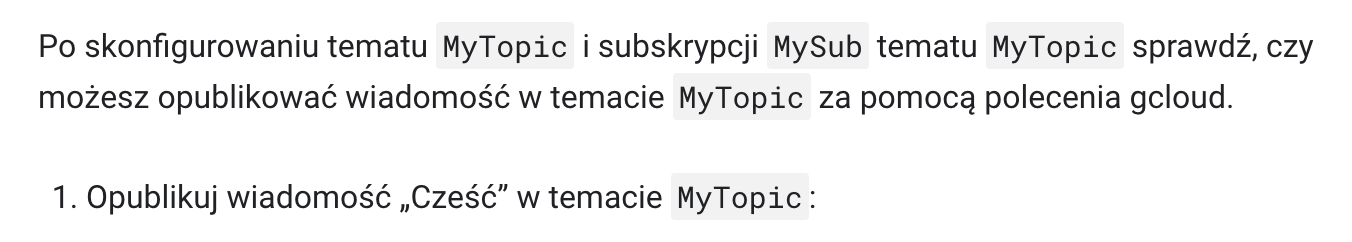

In [ ]:
gcloud pubsub topics publish MyTopic --message "Cześć"

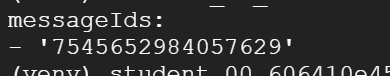

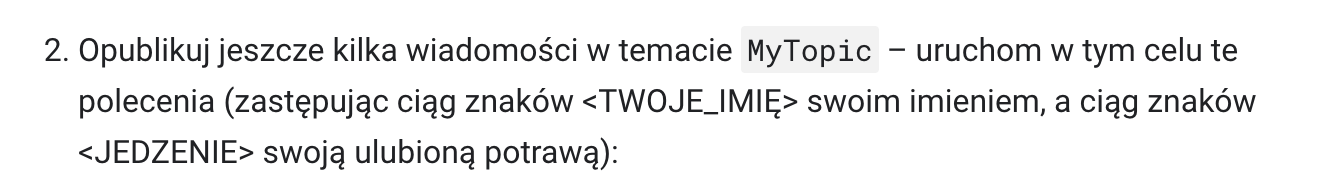

In [ ]:
gcloud pubsub topics publish MyTopic --message "Osobą publikującą wiadomość jest Piotr"

In [ ]:
gcloud pubsub topics publish MyTopic --message "Ulubione jedzenie osoby publikującej wiadomość to Oliwa z oliwek"

In [ ]:
gcloud pubsub topics publish MyTopic --message "Osoba publikująca wiadomość uważa, że Pub/Sub jest super"

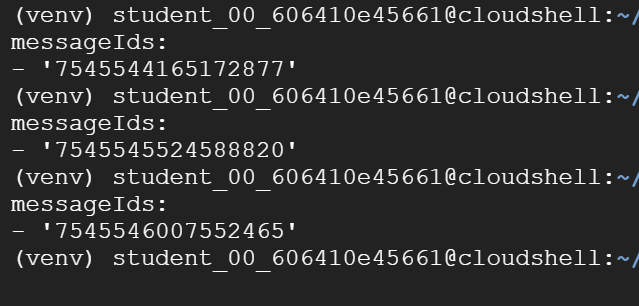

##Zadanie 7. Wyświetl wiadomości

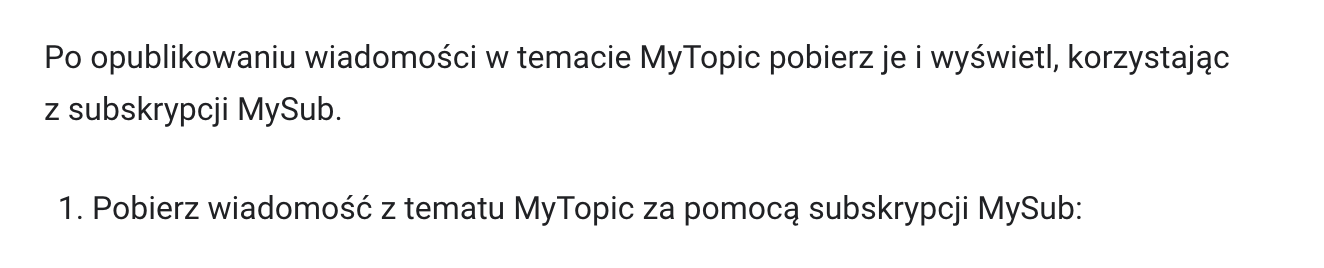

In [ ]:
python subscriber.py $GOOGLE_CLOUD_PROJECT receive MySub

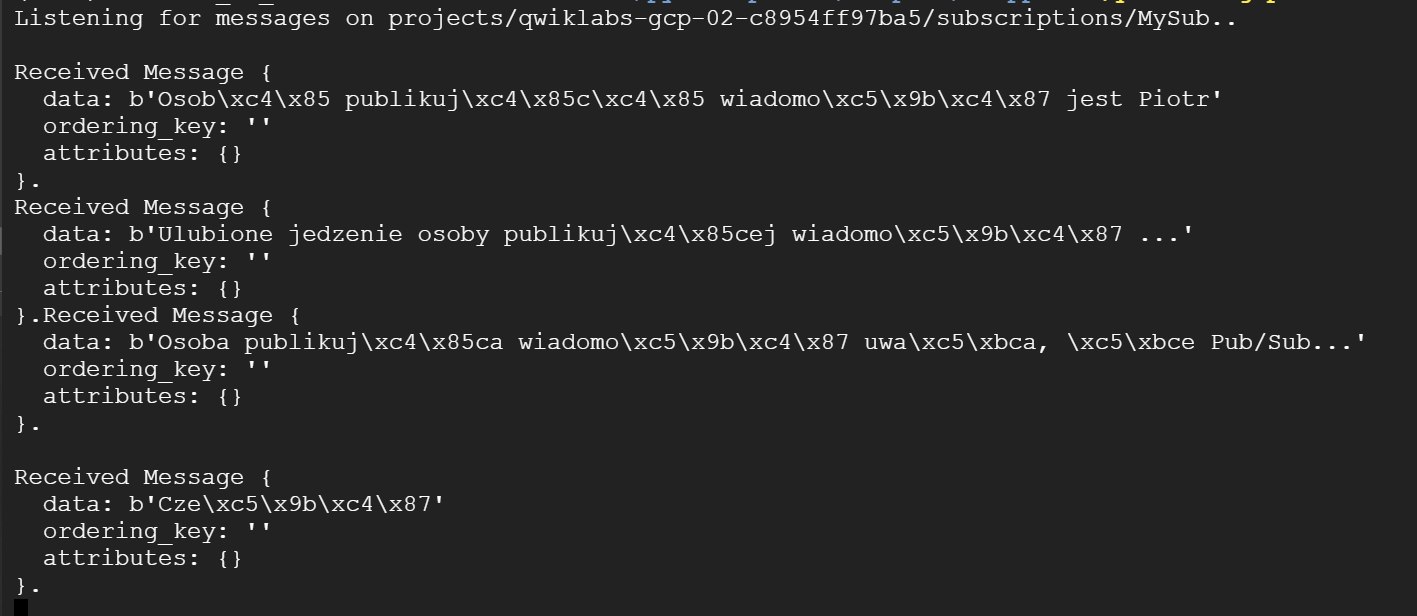

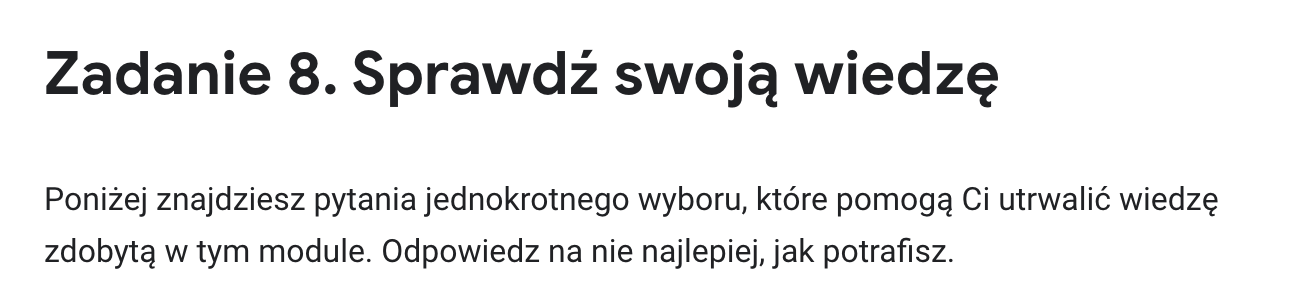

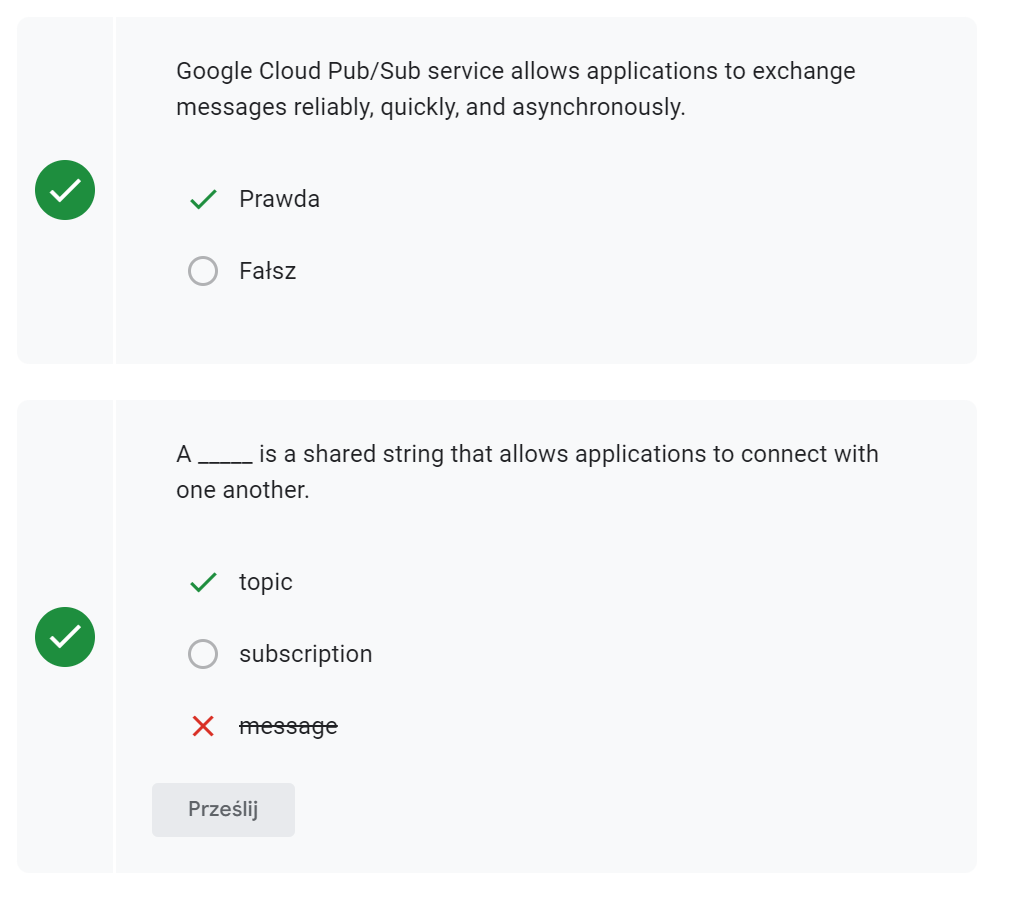